In [471]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import *  
import math
import itertools
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score, classification_report, 
    roc_curve, auc, confusion_matrix, plot_confusion_matrix, precision_recall_fscore_support, f1_score,precision_score,recall_score, plot_roc_curve,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
from scikitplot.metrics import plot_roc, plot_confusion_matrix, plot_precision_recall
import catboost as cb
import shap
from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
import xgboost as xgb



IMPORTAR DATA

In [361]:
df = pd.read_excel('online_retail_II.xlsx', dtype={'Invoice': str, 'StockCode': str, 'Description': str,'Quantity': int,'Price': float, 'Customer ID': str, 'Country': str, 'InvoiceDate': datetime})

In [362]:
print(df)
df.shape

       Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
525456  538171     22271                 FELTCRAFT DOLL ROSIE         2   
525457  538171     22750         FELTCRAFT PRINCESS LOLA DOLL         1   
525458  538171     22751       FELTCRAFT PRINCESS OLIVIA DOLL         1   
525459  538171     20970   PINK FLORAL FELTCRAFT SHOULDER BAG         2   
525460  538171     21931               JUMBO STORAGE BAG SUKI         2   

               InvoiceDate  Price Customer ID         Country  
0      2009-12-01 07:45:00   6.95  

(525461, 8)

In [363]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [5]:
print(df.dtypes)

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
dtype: object


In [6]:
#creo que este paso no hace falta
# df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%Y-%m-%d %H:%M:%S')

In [364]:
#separo date y time en dos variables distintas y les asigno su formato
df['Time'] = [d.time() for d in df['InvoiceDate']]
df['Date'] = [d.date() for d in df['InvoiceDate']]


In [365]:
#Crear variable Day of Week
df['DayOfWeek'] =df['InvoiceDate'].dt.dayofweek

In [366]:
#Crear variable binaria Weekend
df['Weekend'] =((df['DayOfWeek']==5) | (df['DayOfWeek']==6))

In [10]:
#df=df.drop(['InvoiceDate',], axis=1)

In [367]:
#crear variable Cancellation (Facturas que empiezan con C)
df["Cancellation"] = np.where(df['Invoice'].str.get(0)=="C", 1, 0)

In [368]:
#cambiar nombre customer id para facilitar
df.rename({'Customer ID': 'CustomerID'}, axis=1, inplace=True)

PRIMER EDA 

In [13]:
#summary
df.describe()

,Quantity,Price,DayOfWeek,Cancellation
count,525461.000000,525461.000000,525461.000000,525461.000000
mean,10.337667,4.688834,2.495709,0.019423
std,107.424110,146.126914,1.916019,0.138006
min,-9600.000000,-53594.360000,0.000000,0.000000
25%,1.000000,1.250000,1.000000,0.000000
50%,3.000000,2.100000,2.000000,0.000000
75%,10.000000,4.210000,4.000000,0.000000
max,19152.000000,25111.090000,6.000000,1.000000


In [14]:
df.shape

(525461, 13)

In [15]:
#head
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Time,Date,DayOfWeek,Weekend,Cancellation
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,07:45:00,2009-12-01,1,False,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,07:45:00,2009-12-01,1,False,0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,07:45:00,2009-12-01,1,False,0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,07:45:00,2009-12-01,1,False,0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,07:45:00,2009-12-01,1,False,0


In [16]:
#missing values
#df.isnull().sum()
(df.isnull().sum() / df.shape[0]) * 100


Invoice          0.000000
StockCode        0.000000
Description      0.557225
Quantity         0.000000
InvoiceDate      0.000000
Price            0.000000
CustomerID      20.539488
Country          0.000000
Time             0.000000
Date             0.000000
DayOfWeek        0.000000
Weekend          0.000000
Cancellation     0.000000
dtype: float64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Invoice       525461 non-null  object        
 1   StockCode     525461 non-null  object        
 2   Description   522533 non-null  object        
 3   Quantity      525461 non-null  int64         
 4   InvoiceDate   525461 non-null  datetime64[ns]
 5   Price         525461 non-null  float64       
 6   CustomerID    417534 non-null  object        
 7   Country       525461 non-null  object        
 8   Time          525461 non-null  object        
 9   Date          525461 non-null  object        
 10  DayOfWeek     525461 non-null  int64         
 11  Weekend       525461 non-null  bool          
 12  Cancellation  525461 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 48.6+ MB


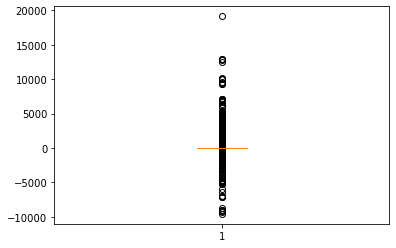

In [18]:
#OUTLIERS QUANTITY 
y = list(df['Quantity'])
plt.boxplot(y)
plt.show()


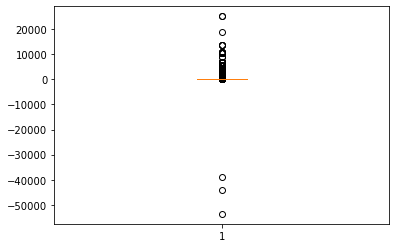

In [19]:
#OUTLIERS PRICE 
y = list(df['Price'])
plt.boxplot(y)
plt.show()

Primeras cosas llamativas:
- hay cantidades y precios negativos
- mucha divergencia en dichos valores
- hay muchas descripciones y customer ids missing

In [20]:
df[(df.Quantity <0)] 
#dos tipos 
#los que son de cancelaciones (cant negativa porque se devuelve al inventario)
#los que no son de cancelacones

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Time,Date,DayOfWeek,Weekend,Cancellation
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia,10:33:00,2009-12-01,1,False,1
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia,10:33:00,2009-12-01,1,False,1
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia,10:33:00,2009-12-01,1,False,1
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia,10:33:00,2009-12-01,1,False,1
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia,10:33:00,2009-12-01,1,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN,United Kingdom,17:17:00,2010-12-09,3,False,0
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN,United Kingdom,17:17:00,2010-12-09,3,False,0
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom,17:25:00,2010-12-09,3,False,0
525235,538162,46000M,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom,17:25:00,2010-12-09,3,False,0


In [21]:
df[(df.Quantity <0) & (df.Cancellation==False)] 
#df[(df.Quantity <0) & (df.Cancellation==False) & (df.Price>0)] 
#las que no son de cancelacion tienen todas price 0, no tienen customer ID
#df[(df.Quantity <0) & (df.Cancellation==False) & (df.Country !="United Kingdom")] 
#todas esas entradas pertenecen al Reino Unido

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Time,Date,DayOfWeek,Weekend,Cancellation
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.0,NaN,United Kingdom,10:52:00,2009-12-01,1,False,0
283,489463,71477,short,-240,2009-12-01 10:52:00,0.0,NaN,United Kingdom,10:52:00,2009-12-01,1,False,0
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.0,NaN,United Kingdom,10:53:00,2009-12-01,1,False,0
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom,11:44:00,2009-12-01,1,False,0
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom,17:26:00,2009-12-01,1,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
524458,538092,37467,NaN,-177,2010-12-09 14:49:00,0.0,NaN,United Kingdom,14:49:00,2010-12-09,3,False,0
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.0,NaN,United Kingdom,17:17:00,2010-12-09,3,False,0
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.0,NaN,United Kingdom,17:17:00,2010-12-09,3,False,0
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.0,NaN,United Kingdom,17:25:00,2010-12-09,3,False,0


In [22]:
df[(df.Quantity ==0)] 
#no hay entradas con quantity 0

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Time,Date,DayOfWeek,Weekend,Cancellation


In [369]:
#Elimino entradas con cantidad negativa que no sean de cancelaciones
#No se a que se debe esas transacciones, pero no aportan informacion para las cancelaciones y si confunde
df.drop(df[(df.Quantity <0) & (df.Cancellation==False)].index, inplace = True)

In [24]:
df[(df.Price <0)] 
#tres casos que tienen Adjust bad debt como codigo
#es un tema de balance de cuentas de la empresa no tiene relacion con sus transacciones y los cambios asi que lo elimino

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Time,Date,DayOfWeek,Weekend,Cancellation
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom,13:36:00,2010-04-29,3,False,0
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom,11:24:00,2010-07-19,0,False,0
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom,12:04:00,2010-10-20,2,False,0


In [370]:
df.drop(df[(df.Price <0)].index, inplace = True)

In [26]:
df[(df.Price ==0)] 
#df[(df.Price ==0) & (df.Cancellation==True)] 
#hay transacciones con precio 0, ninugna corresponde a una cancelacion
#asumo que son por promocion o regalo y por eso son "gratis"

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Time,Date,DayOfWeek,Weekend,Cancellation
3161,489659,21350,NaN,230,2009-12-01 17:39:00,0.0,NaN,United Kingdom,17:39:00,2009-12-01,1,False,0
3731,489781,84292,NaN,17,2009-12-02 11:45:00,0.0,NaN,United Kingdom,11:45:00,2009-12-02,2,False,0
4674,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.0,16126,United Kingdom,13:34:00,2009-12-02,2,False,0
5904,489861,DOT,DOTCOM POSTAGE,1,2009-12-02 14:50:00,0.0,NaN,United Kingdom,14:50:00,2009-12-02,2,False,0
6378,489882,35751C,NaN,12,2009-12-02 16:22:00,0.0,NaN,United Kingdom,16:22:00,2009-12-02,2,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
524728,538142,84247C,NaN,1,2010-12-09 15:58:00,0.0,NaN,United Kingdom,15:58:00,2010-12-09,3,False,0
524729,538144,90042B,NaN,1,2010-12-09 15:58:00,0.0,NaN,United Kingdom,15:58:00,2010-12-09,3,False,0
524730,538141,22218,NaN,2,2010-12-09 15:58:00,0.0,NaN,United Kingdom,15:58:00,2010-12-09,3,False,0
524731,538143,84534B,NaN,1,2010-12-09 15:58:00,0.0,NaN,United Kingdom,15:58:00,2010-12-09,3,False,0


In [27]:
df[(df.CustomerID.isnull())]
#df[(df.CustomerID.isnull())& (df.Cancellation==False)]
#df[(df.CustomerID.isnull())& (df.Cancellation==True)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Time,Date,DayOfWeek,Weekend,Cancellation
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom,11:49:00,2009-12-01,1,False,0
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom,11:49:00,2009-12-01,1,False,0
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom,12:32:00,2009-12-01,1,False,0
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom,12:32:00,2009-12-01,1,False,0
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom,12:32:00,2009-12-01,1,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525144,538154,84029E,RED WOOLLY HOTTIE WHITE HEART.,5,2010-12-09 16:35:00,8.47,NaN,United Kingdom,16:35:00,2010-12-09,3,False,0
525145,538154,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2010-12-09 16:35:00,8.47,NaN,United Kingdom,16:35:00,2010-12-09,3,False,0
525146,538154,85099B,JUMBO BAG RED RETROSPOT,1,2010-12-09 16:35:00,4.21,NaN,United Kingdom,16:35:00,2010-12-09,3,False,0
525147,538154,DOT,DOTCOM POSTAGE,1,2010-12-09 16:35:00,85.79,NaN,United Kingdom,16:35:00,2010-12-09,3,False,0


In [371]:
#pasar quantity de cancellation a positivo
df["Quantity"] = np.where(df["Cancellation"] == True, df["Quantity"]*(-1), df["Quantity"])

In [29]:
#verifico
#df[(df.Quantity <0) & (df.Cancellation==False)] 
df[(df.Quantity <0)]
#habia un dato que era cancellation y positivo, por lo que ahora quedo negativo --> lo cambio

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Time,Date,DayOfWeek,Weekend,Cancellation
76799,C496350,M,Manual,-1,2010-02-01 08:24:00,373.57,NaN,United Kingdom,08:24:00,2010-02-01,0,False,1


In [372]:
df["Quantity"] = np.where(df["Quantity"]<0 , df["Quantity"]*(-1), df["Quantity"])

In [31]:
df.Country.value_counts()

United Kingdom          483728
EIRE                      9670
Germany                   8129
France                    5772
Netherlands               2769
Spain                     1278
Switzerland               1187
Portugal                  1101
Belgium                   1054
Channel Islands            906
Sweden                     902
Italy                      731
Australia                  654
Cyprus                     554
Austria                    537
Greece                     517
United Arab Emirates       432
Denmark                    428
Norway                     369
Finland                    354
Unspecified                310
USA                        244
Japan                      224
Poland                     194
Malta                      172
Lithuania                  154
Singapore                  117
RSA                        111
Bahrain                    107
Canada                      77
Hong Kong                   76
Thailand                    76
Israel  

In [32]:
df.DayOfWeek.value_counts()

3    98871
1    94335
0    93633
2    90111
6    74880
4    71107
5      400
Name: DayOfWeek, dtype: int64

In [33]:
df.Cancellation.value_counts()

0    513131
1     10206
Name: Cancellation, dtype: int64

In [373]:
#cambio el formato de la tabla --> antes estaba desagregado por cada item de la factura --> despues quiero que cada factura represente una entrada
#lo armo en un dataframe aparte por las dudas (conservar dataset original)
dforig=df
print(dforig)

       Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
525456  538171     22271                 FELTCRAFT DOLL ROSIE         2   
525457  538171     22750         FELTCRAFT PRINCESS LOLA DOLL         1   
525458  538171     22751       FELTCRAFT PRINCESS OLIVIA DOLL         1   
525459  538171     20970   PINK FLORAL FELTCRAFT SHOULDER BAG         2   
525460  538171     21931               JUMBO STORAGE BAG SUKI         2   

               InvoiceDate  Price CustomerID         Country      Time  \
0      2009-12-01 07:45:0

In [374]:
#creo la variable que represente el cargo de envio
# condiciones
conditions = [
    (df['StockCode']== 'POST'),
    (df['StockCode']== 'DOT')
    ]

# valores
values = [df.Price*df.Quantity, df.Price*df.Quantity]

# nueva columna
df['Postage'] = np.select(conditions, values)


In [36]:
#verifico
df[(df.Postage <0)] 

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Time,Date,DayOfWeek,Weekend,Cancellation,Postage


In [375]:
#modifico el precio y la cantidad en los items de envio como 0, ya que se suma desde la columna de envio y no dentro del detalle de la factura
df["Quantity"] = np.where(df["StockCode"] == "POST", 0, df["Quantity"])
df["Quantity"] = np.where(df["StockCode"] == "DOT", 0, df["Quantity"])
df["Price"] = np.where(df["StockCode"] == "POST", 0, df["Price"])
df["Price"] = np.where(df["StockCode"] == "DOT", 0, df["Price"])

In [376]:
#verifico
#df[(df.Price==0)&(df.Postage==0)] #hay entradas con price 0 por lo de lo que asumi son promociones
df[(df.Quantity==0)&(df.Postage==0)] #hay entradas con cantidad de postage 0, asumo que sifnifica que no tiene postage y se agrego ese detalle en la factura

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Time,Date,DayOfWeek,Weekend,Cancellation,Postage
5904,489861,DOT,DOTCOM POSTAGE,0,2009-12-02 14:50:00,0.0,NaN,United Kingdom,14:50:00,2009-12-02,2,False,0,0.0
129167,501683,DOT,DOTCOM POSTAGE,0,2010-03-18 16:32:00,0.0,NaN,United Kingdom,16:32:00,2010-03-18,3,False,0,0.0
191175,507450,POST,NaN,0,2010-05-10 10:01:00,0.0,NaN,United Kingdom,10:01:00,2010-05-10,0,False,0,0.0
270781,515611,DOT,DOTCOM POSTAGE,0,2010-07-13 15:52:00,0.0,NaN,United Kingdom,15:52:00,2010-07-13,1,False,0,0.0
271469,515757,DOT,NaN,0,2010-07-14 13:33:00,0.0,NaN,United Kingdom,13:33:00,2010-07-14,2,False,0,0.0
431450,530609,POST,NaN,0,2010-11-03 15:25:00,0.0,NaN,United Kingdom,15:25:00,2010-11-03,2,False,0,0.0
444336,531758,POST,NaN,0,2010-11-09 13:26:00,0.0,NaN,United Kingdom,13:26:00,2010-11-09,1,False,0,0.0


In [377]:
#creo variable amount
df['Amount'] =(df['Price']*df['Quantity'])

In [378]:
#elimino las variables description y stock code
df=df.drop(['StockCode',], axis=1)
df=df.drop(['Description',], axis=1)

In [379]:
#creo la variable item para despues registrar la cantidad de items distintos que tiene cada compra
df['Items']=(1)

In [42]:
print(df)

       Invoice  Quantity         InvoiceDate  Price CustomerID  \
0       489434        12 2009-12-01 07:45:00   6.95      13085   
1       489434        12 2009-12-01 07:45:00   6.75      13085   
2       489434        12 2009-12-01 07:45:00   6.75      13085   
3       489434        48 2009-12-01 07:45:00   2.10      13085   
4       489434        24 2009-12-01 07:45:00   1.25      13085   
...        ...       ...                 ...    ...        ...   
525456  538171         2 2010-12-09 20:01:00   2.95      17530   
525457  538171         1 2010-12-09 20:01:00   3.75      17530   
525458  538171         1 2010-12-09 20:01:00   3.75      17530   
525459  538171         2 2010-12-09 20:01:00   3.75      17530   
525460  538171         2 2010-12-09 20:01:00   1.95      17530   

               Country      Time        Date  DayOfWeek  Weekend  \
0       United Kingdom  07:45:00  2009-12-01          1    False   
1       United Kingdom  07:45:00  2009-12-01          1    False   
2  

In [380]:
#juntar todo en una entrada por factura
df=df.groupby(['Invoice', 'CustomerID', 'Country', 'InvoiceDate', 'Time', 'Date', 'DayOfWeek', 'Weekend', 'Cancellation'], as_index=False).agg({"Postage": "sum", "Amount": "sum", "Quantity": "sum","Price": "mean", "Items": "sum"})

In [381]:
#creo variable total
df['Total'] =(df['Amount']+df['Postage'])

In [382]:
#el precio ahora es el precio promedio por unidad de la factura
df.rename({'Price': 'AvgUnitPrice'}, axis=1, inplace=True)

EDA

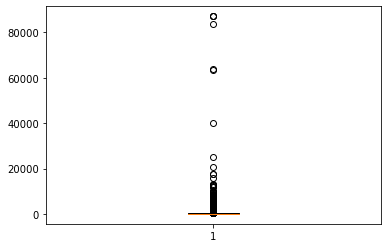

In [46]:
#OUTLIERS QUANTITY 
y = list(df['Quantity'])
plt.boxplot(y)
plt.show()

In [47]:
df[(df.Quantity >10000)] 

,Invoice,CustomerID,Country,InvoiceDate,Time,Date,DayOfWeek,Weekend,Cancellation,Postage,Amount,Quantity,AvgUnitPrice,Items,Total
246,490018,17940,United Kingdom,2009-12-03 12:31:00,12:31:00,2009-12-03,3,False,0,0.0,4380.00,17520,0.250000,4,4380.00
1047,491812,13694,United Kingdom,2009-12-14 13:23:00,13:23:00,2009-12-14,0,False,0,0.0,13854.20,20524,1.001770,113,13854.20
1605,493819,14156,EIRE,2010-01-07 12:34:00,12:34:00,2010-01-07,3,False,0,0.0,44051.60,25018,2.427553,94,44051.60
2097,495194,13902,Denmark,2010-01-21 15:11:00,15:11:00,2010-01-21,3,False,0,0.0,6989.40,63302,0.138000,15,6989.40
2253,495591,14646,Netherlands,2010-01-26 10:25:00,10:25:00,2010-01-26,1,False,0,0.0,18570.88,12832,1.842889,90,18570.88
3065,497946,13902,Denmark,2010-02-15 11:57:00,11:57:00,2010-02-15,0,False,0,0.0,16973.10,83774,0.265000,30,16973.10
4382,501534,13902,Denmark,2010-03-17 13:09:00,13:09:00,2010-03-17,2,False,0,0.0,6866.30,63974,0.190000,10,6866.30
4698,502269,17940,United Kingdom,2010-03-23 15:36:00,15:36:00,2010-03-23,1,False,0,0.0,10000.00,40000,0.250000,4,10000.00
7246,508748,17940,United Kingdom,2010-05-18 11:45:00,11:45:00,2010-05-18,1,False,0,0.0,6250.00,12500,0.500000,3,6250.00
7536,509472,18052,United Kingdom,2010-05-24 11:11:00,11:11:00,2010-05-24,0,False,0,0.0,10877.18,17766,0.656250,16,10877.18


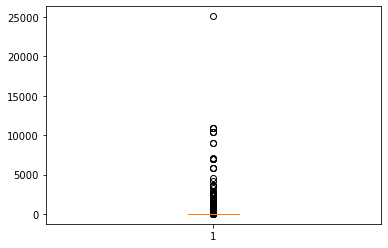

In [48]:
#OUTLIERS PRICE 
y = list(df['AvgUnitPrice'])
plt.boxplot(y)
plt.show()

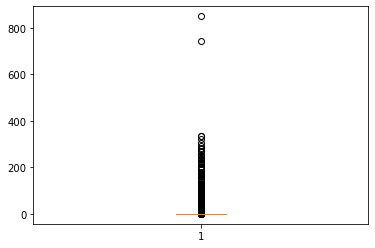

In [49]:
#OUTLIERS POSTAGE 
y = list(df['Postage'])
plt.boxplot(y)
plt.show()

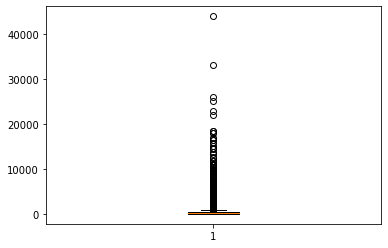

In [50]:
#OUTLIERS AMOUNT 
y = list(df['Amount'])
plt.boxplot(y)
plt.show()

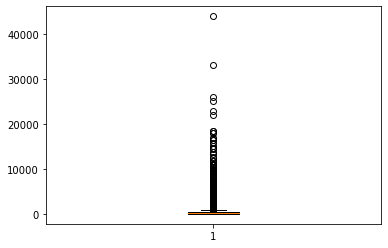

In [51]:
#OUTLIERS TOTAL 
y = list(df['Total'])
plt.boxplot(y)
plt.show()

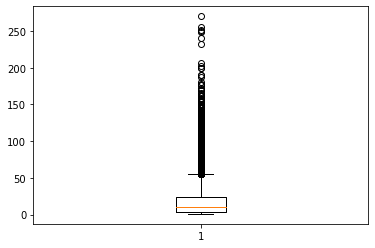

In [52]:
#OUTLIERS ITEMS 
y = list(df['Items'])
plt.boxplot(y)
plt.show()

In [53]:
#desviacion estandar
df[['Quantity', 'AvgUnitPrice', 'Amount', 'Postage','Total', 'Items' ]].std() 

Quantity        1407.055706
AvgUnitPrice     298.019439
Amount           899.489880
Postage           16.879167
Total            899.960743
Items             21.306603
dtype: float64

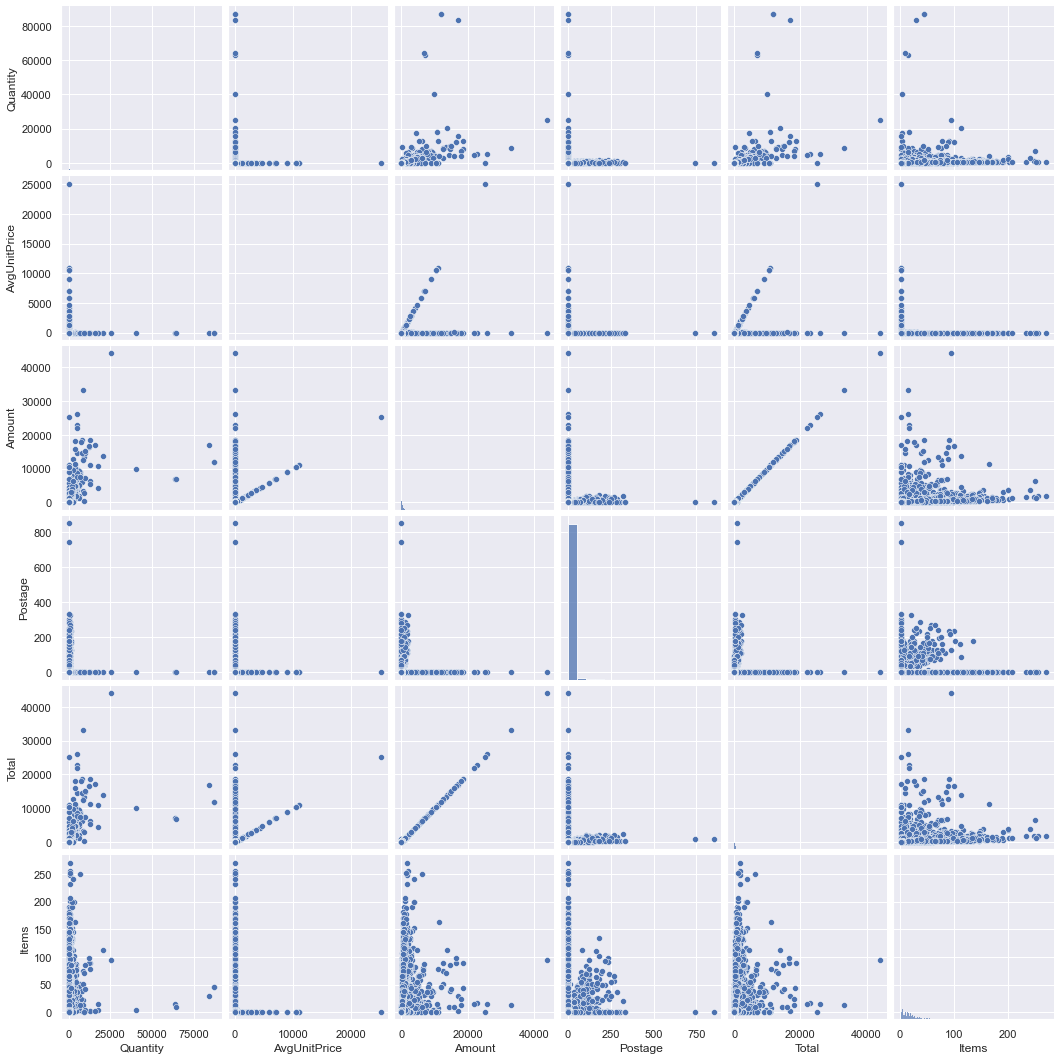

In [54]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.pairplot(data = df, vars=['Quantity', 'AvgUnitPrice', 'Amount', 'Postage','Total', 'Items'])
plt.show()

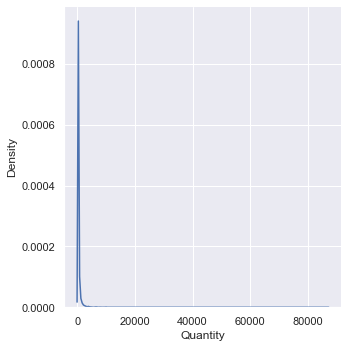

In [55]:
#distribuciones
sns.displot(df, x="Quantity", kind="kde", bw_adjust=.25)

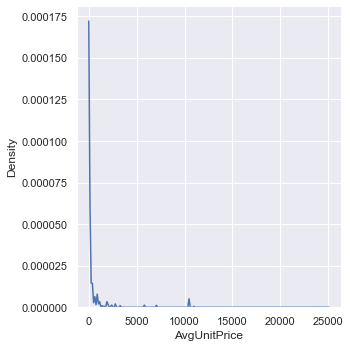

In [56]:
sns.displot(df, x="AvgUnitPrice", kind="kde", bw_adjust=.25)

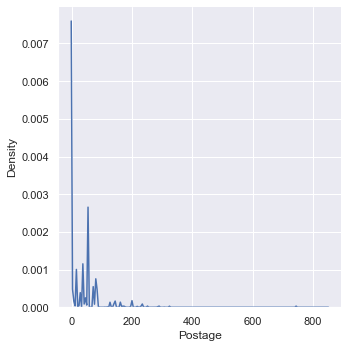

In [57]:
sns.displot(df, x="Postage", kind="kde", bw_adjust=.25)

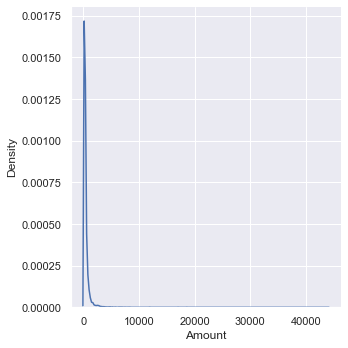

In [58]:
sns.displot(df, x="Amount", kind="kde", bw_adjust=.25)

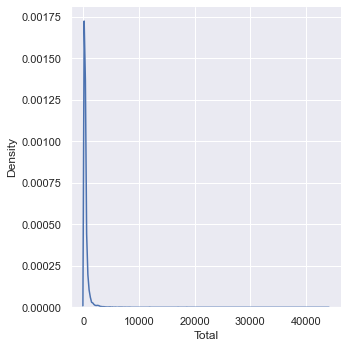

In [59]:
sns.displot(df, x="Total", kind="kde", bw_adjust=.25)

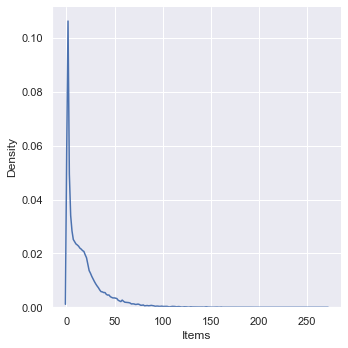

In [60]:
sns.displot(df, x="Items", kind="kde", bw_adjust=.25)

<AxesSubplot:>

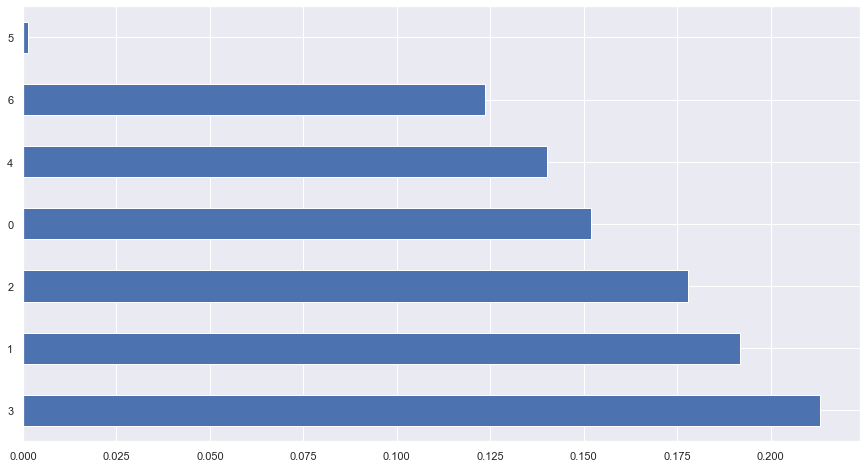

In [61]:
df["DayOfWeek"].value_counts() 
df.DayOfWeek.value_counts(normalize=True).plot.barh()

<AxesSubplot:>

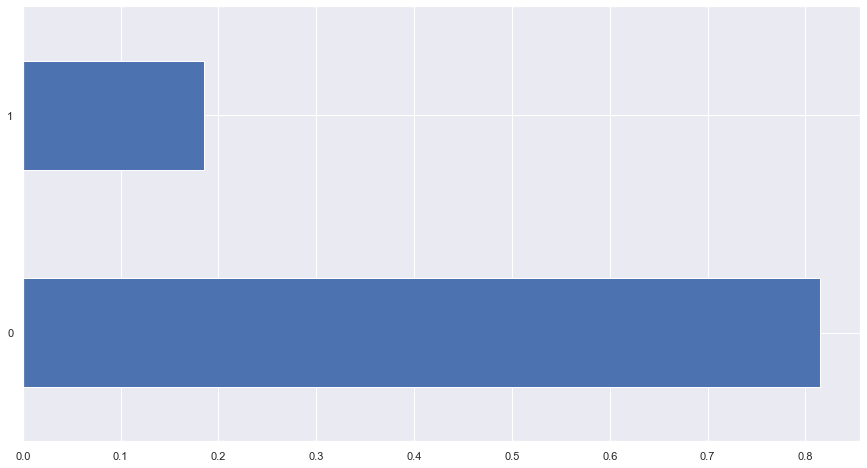

In [62]:
df["Cancellation"].value_counts() 
df.Cancellation.value_counts(normalize=True).plot.barh()

<AxesSubplot:>

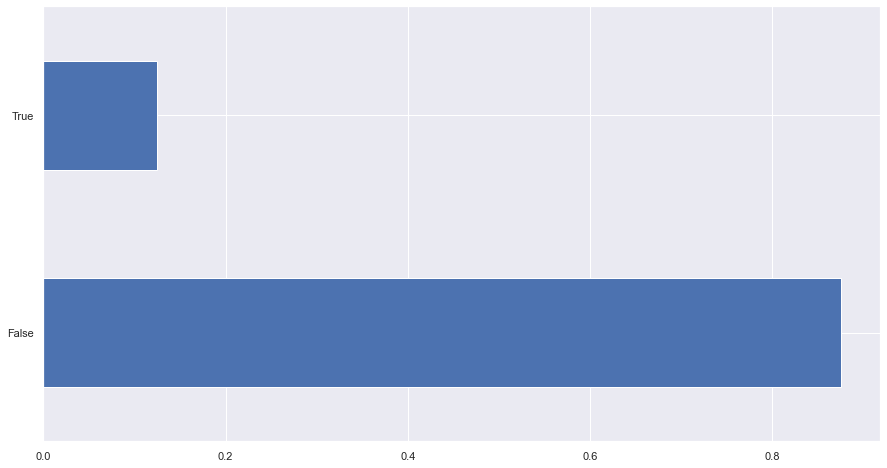

In [63]:
df["Weekend"].value_counts() 
df.Weekend.value_counts(normalize=True).plot.barh()

<AxesSubplot:>

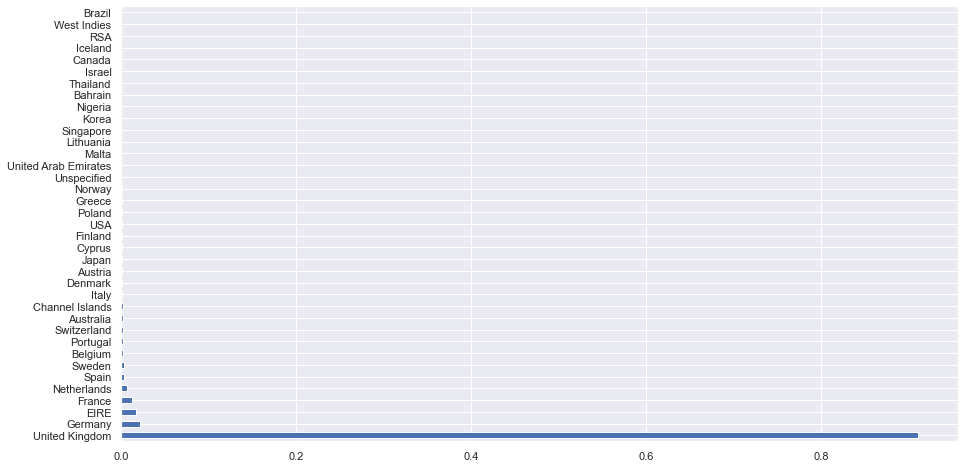

In [64]:
df["Country"].value_counts() 
df.Country.value_counts(normalize=True).plot.barh()

In [65]:
#correlaciones
df.corr(method='spearman')

,DayOfWeek,Weekend,Cancellation,Postage,Amount,Quantity,AvgUnitPrice,Items,Total
DayOfWeek,1.000000,0.581624,-0.040646,-0.004867,0.013505,0.012077,0.003487,0.063222,0.012343
Weekend,0.581624,1.000000,-0.097644,-0.021497,0.043145,0.049059,-0.012005,0.140558,0.041684
Cancellation,-0.040646,-0.097644,1.000000,-0.041473,-0.556353,-0.583601,0.185051,-0.542725,-0.558585
Postage,-0.004867,-0.021497,-0.041473,1.000000,0.034922,0.046000,-0.118115,0.039031,0.076532
Amount,0.013505,0.043145,-0.556353,0.034922,1.000000,0.875816,-0.062485,0.654956,0.997159
Quantity,0.012077,0.049059,-0.583601,0.046000,0.875816,1.000000,-0.387422,0.688286,0.873025
AvgUnitPrice,0.003487,-0.012005,0.185051,-0.118115,-0.062485,-0.387422,1.000000,-0.150991,-0.070590
Items,0.063222,0.140558,-0.542725,0.039031,0.654956,0.688286,-0.150991,1.000000,0.652622
Total,0.012343,0.041684,-0.558585,0.076532,0.997159,0.873025,-0.070590,0.652622,1.000000


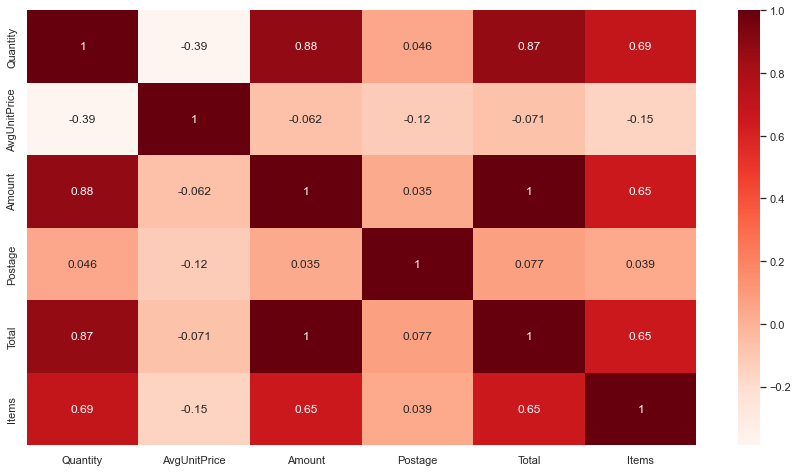

In [66]:
# Creating a matrix 
#poner spearman vs pearson
df[['Quantity', 'AvgUnitPrice', 'Amount', 'Postage','Total']].corr(method='spearman')

#plot the correlation matrix of salary, balance and age in data dataframe.
sns.heatmap(df[['Quantity', 'AvgUnitPrice', 'Amount', 'Postage','Total', 'Items']].corr(method='spearman'), annot=True, cmap = 'Reds')
plt.show()

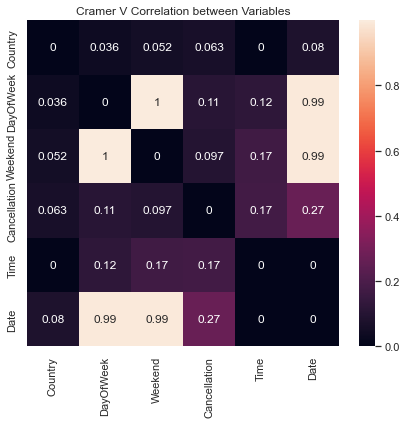

In [67]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


cols = ["Country", "DayOfWeek", "Weekend", "Cancellation", "Time", "Date"]
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df[col1], df[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");

In [68]:
ss.pointbiserialr(df.Cancellation, df.Quantity)

PointbiserialrResult(correlation=-0.0660182504730692, pvalue=3.078309806384531e-24)

In [69]:
ss.pointbiserialr(df.Cancellation, df.Amount)

PointbiserialrResult(correlation=-0.149544305268321, pvalue=3.426990318242768e-118)

In [70]:
ss.pointbiserialr(df.Cancellation, df.AvgUnitPrice)

PointbiserialrResult(correlation=0.06480975111187906, pvalue=2.044541242711416e-23)

In [71]:
ss.pointbiserialr(df.Cancellation, df.Total)

PointbiserialrResult(correlation=-0.15024087711736583, pvalue=2.736739415096053e-119)

In [72]:
ss.pointbiserialr(df.Cancellation, df.Postage)

PointbiserialrResult(correlation=-0.04131140741319636, pvalue=2.1293229426196508e-10)

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


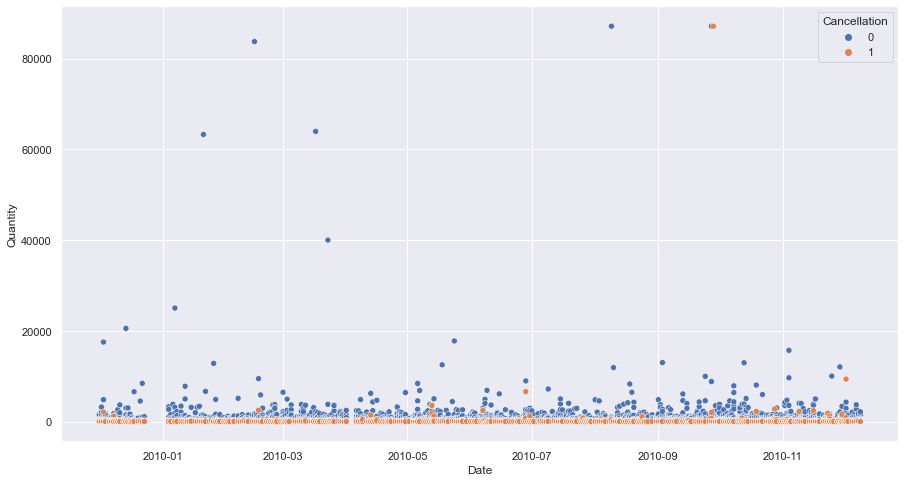

In [73]:
sns.scatterplot('Date', 'Quantity', data=df, hue='Cancellation')
plt.show()

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


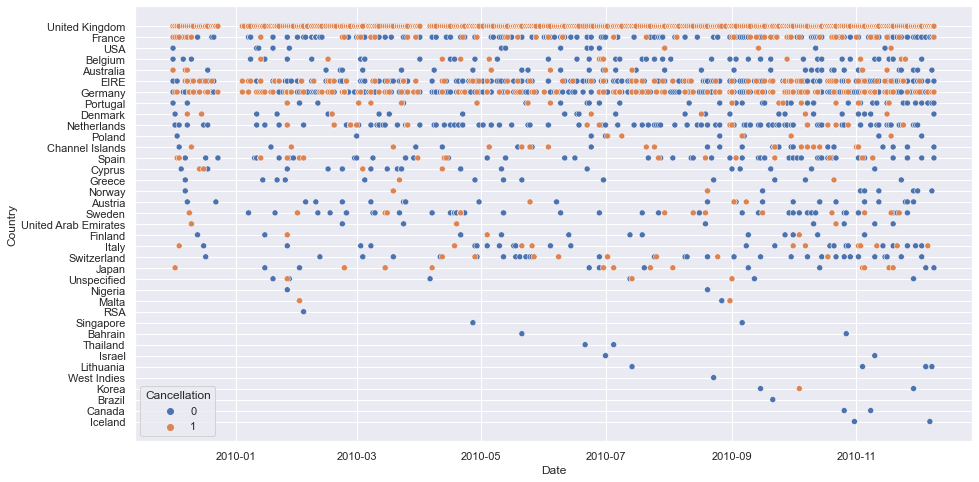

In [74]:
sns.scatterplot('Date', 'Country', data=df, hue='Cancellation')
plt.show()

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


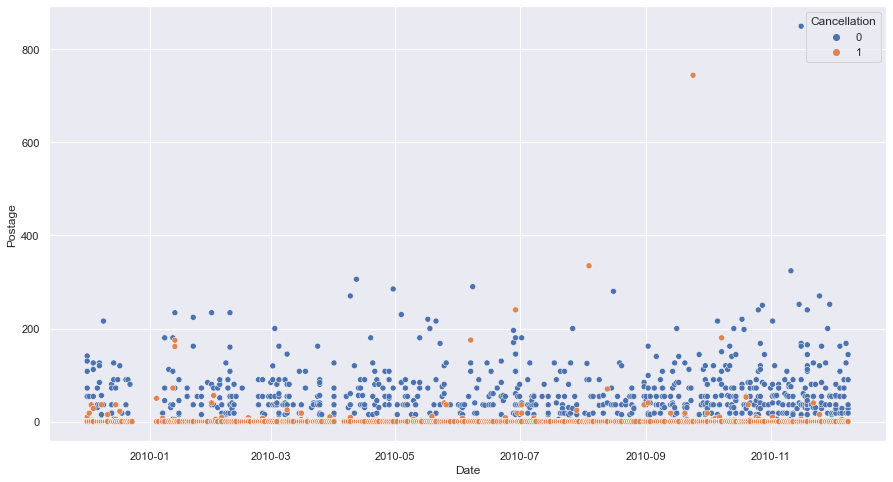

In [75]:
sns.scatterplot('Date', 'Postage', data=df, hue='Cancellation')
plt.show()

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


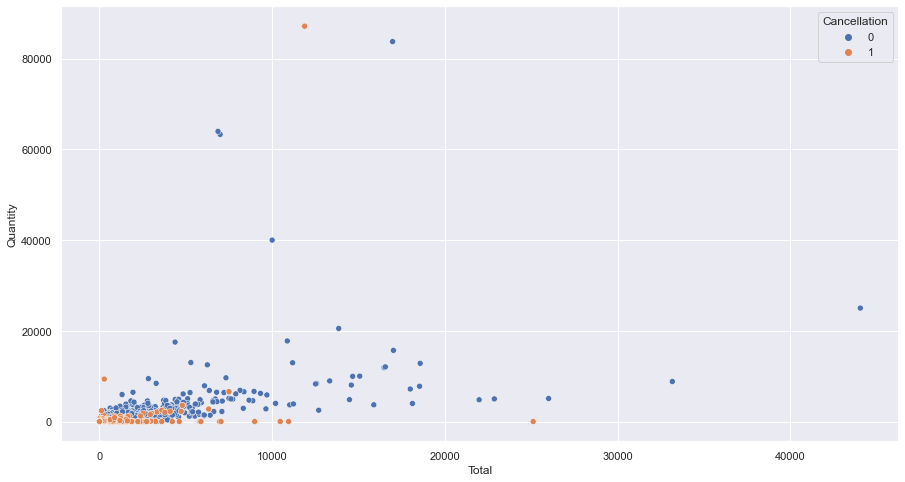

In [76]:
sns.scatterplot('Total', 'Quantity', data=df, hue='Cancellation')
plt.show()

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


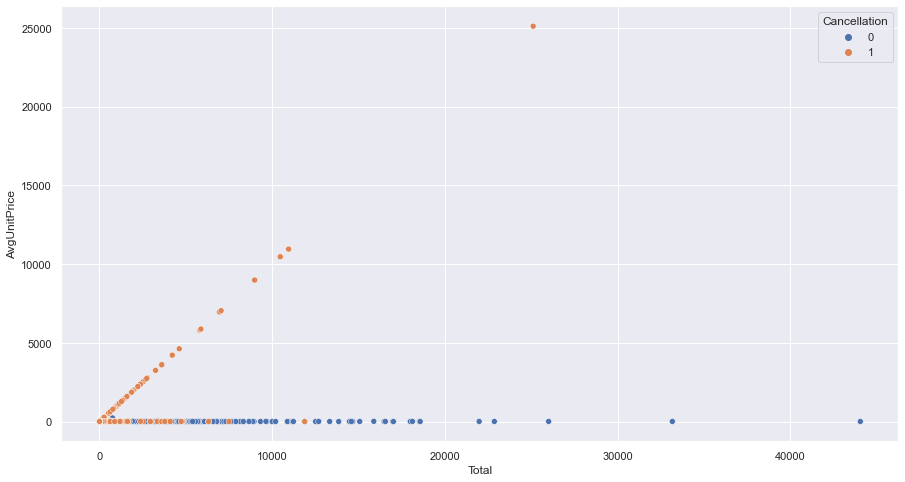

In [77]:
sns.scatterplot('Total', 'AvgUnitPrice', data=df, hue='Cancellation')
plt.show()

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


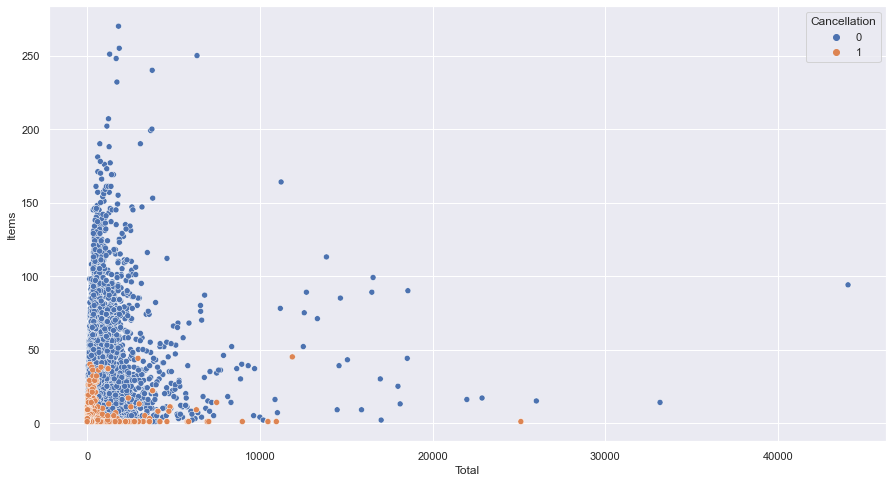

In [78]:
sns.scatterplot('Total', 'Items', data=df, hue='Cancellation')
plt.show()

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


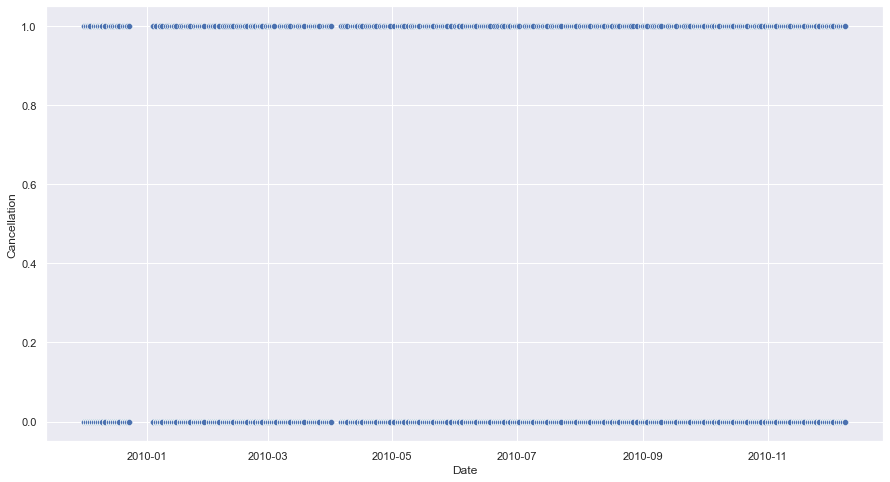

In [79]:
sns.scatterplot('Date', 'Cancellation', data=df)
plt.show()

In [383]:
#Variable Weekday
#Ni One Hot Encoding, ni tratamiento ciclico (porque voy a trabajar con arboles por los outliers)
df.rename({'DayOfWeek': 'WD1'}, axis=1, inplace=True)

In [384]:
df["WD2"] = np.where(df["WD1"]< 6, df["WD1"]+1, 0)
df["WD3"] = np.where(df["WD2"]< 6, df["WD2"]+1, 0)
df["WD4"] = np.where(df["WD3"]< 6, df["WD3"]+1, 0)
df["WD5"] = np.where(df["WD4"]< 6, df["WD4"]+1, 0)
df["WD6"] = np.where(df["WD5"]< 6, df["WD5"]+1, 0)
df["WD7"] = np.where(df["WD6"]< 6, df["WD6"]+1, 0)


In [82]:
print(df)

       Invoice CustomerID         Country         InvoiceDate      Time  \
0       489434      13085  United Kingdom 2009-12-01 07:45:00  07:45:00   
1       489435      13085  United Kingdom 2009-12-01 07:46:00  07:46:00   
2       489436      13078  United Kingdom 2009-12-01 09:06:00  09:06:00   
3       489437      15362  United Kingdom 2009-12-01 09:08:00  09:08:00   
4       489438      18102  United Kingdom 2009-12-01 09:24:00  09:24:00   
...        ...        ...             ...                 ...       ...   
23617  C538121      15535  United Kingdom 2010-12-09 15:36:00  15:36:00   
23618  C538122      14696  United Kingdom 2010-12-09 15:38:00  15:38:00   
23619  C538123      12605         Germany 2010-12-09 15:41:00  15:41:00   
23620  C538124      15329  United Kingdom 2010-12-09 15:43:00  15:43:00   
23621  C538164      14031  United Kingdom 2010-12-09 17:32:00  17:32:00   

             Date  WD1  Weekend  Cancellation  Postage  ...  Quantity  \
0      2009-12-01    1    

In [386]:
def Continent(country):
    if country=='Unspecified':
        continent='Unspecified'
    elif country=='Australia':
        continent='Oceania'
    elif country in ['USA', 'Canada', 'Brazil','West Indies', 'Bermuda']:
        continent='America'
    elif country in ['Japan', 'Singapore', 'Hong-Kong','Thailand', 'Korea']:
        continent='Asia'
    elif country in ['United-Arab-Emirates', 'Bahrain', 'Israel','Lebanon']:
        continent='Middle East'
    elif country in ['RSA', 'Nigeria']:
        continent='Africa'
    elif country in ['United Kingdom']:
        continent='United Kingdom'
    else:
        continent='Europe'
    return continent

In [387]:
df['Continent']=df['Country'].apply(Continent)


In [388]:
df["United Kingdom"] = np.where(df["Continent"]=='United Kingdom', 1, 0)
df["Africa"] = np.where(df["Continent"]=='Africa', 1, 0)
df["America"] = np.where(df["Continent"]=='America', 1, 0)
df["Asia"] = np.where(df["Continent"]=='Asia', 1, 0)
df["Middle East"] = np.where(df["Continent"]=='Middle East', 1, 0)
df["Europe"] = np.where(df["Continent"]=='Europe', 1, 0)
df["Oceania"] = np.where(df["Continent"]=='Oceania', 1, 0)
df["Unspecified"] = np.where(df["Continent"]=='Uspecified', 1, 0)

In [86]:
#pruebas
df[df.Country=='Bahrain']

,Invoice,CustomerID,Country,InvoiceDate,Time,Date,WD1,Weekend,Cancellation,Postage,...,WD7,Continent,United Kingdom,Africa,America,Asia,Middle East,Europe,Oceania,Unspecified
7438,509300,12355,Bahrain,2010-05-21 11:59:00,11:59:00,2010-05-21,4,False,0,0.0,...,3,Middle East,0,0,0,0,1,0,0,0
15634,529304,12353,Bahrain,2010-10-27 12:44:00,12:44:00,2010-10-27,2,False,0,0.0,...,1,Middle East,0,0,0,0,1,0,0,0


In [389]:
df['Date'] = pd.to_numeric(pd.to_datetime(df['Date']))

In [232]:
df.shape

(23622, 30)

TRAIN Y TEST

In [88]:
df1=df[df.InvoiceDate< '2010-10-01']
df2=df[df.InvoiceDate >='2010-10-01']
#de esta forma queda el 74% de los casos de cancellation en df1

In [89]:
df1['InvoiceDate'] = pd.to_numeric(pd.to_datetime(df['InvoiceDate']))
df2['InvoiceDate'] = pd.to_numeric(pd.to_datetime(df['InvoiceDate']))

/var/folders/_0/sch0fh0n543gcfn_9jsr3h840000gn/T/ipykernel_16308/2005811803.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['InvoiceDate'] = pd.to_numeric(pd.to_datetime(df['InvoiceDate']))
/var/folders/_0/sch0fh0n543gcfn_9jsr3h840000gn/T/ipykernel_16308/2005811803.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['InvoiceDate'] = pd.to_numeric(pd.to_datetime(df['InvoiceDate']))


In [90]:
print(df1.dtypes)

Invoice            object
CustomerID         object
Country            object
InvoiceDate         int64
Time               object
Date                int64
WD1                 int64
Weekend              bool
Cancellation        int64
Postage           float64
Amount            float64
Quantity            int64
AvgUnitPrice      float64
Items               int64
Total             float64
WD2                 int64
WD3                 int64
WD4                 int64
WD5                 int64
WD6                 int64
WD7                 int64
Continent          object
United Kingdom      int64
Africa              int64
America             int64
Asia                int64
Middle East         int64
Europe              int64
Oceania             int64
Unspecified         int64
dtype: object


In [91]:
#separo el nombre de las columnas
columns_train=list(df1.columns)
datavalues_train=df1[:].values

#separo el nombre de las columnas
columns_test=list(df2.columns)
datavalues_test=df2[:].values

In [92]:
#Data Frame
df1=pd.DataFrame(data=datavalues_train,columns=columns_train)
#Data Frame
df2=pd.DataFrame(data=datavalues_test,columns=columns_test)

In [93]:
#separar en x e y para hacer un pandas dataframe
TargetVariable='Cancellation'
Predictors=['CustomerID','United Kingdom','Africa','America','Asia','Europe', 'Middle East','Oceania','Unspecified','InvoiceDate','Date','WD1','WD2','WD3','WD4','WD5','WD6','WD7','Weekend','Postage','Amount','Quantity','AvgUnitPrice','Items','Total']

In [94]:
X_train=df1[Predictors].values
y_train=df1[TargetVariable].values

In [95]:
X_test, X_val, y_test, y_val = train_test_split(df2[Predictors].values, df2[TargetVariable].values, test_size=0.5, random_state=42)

In [108]:
print(y_test.dtype)

object


MODELOS

DECISION TREE

In [347]:
random_grid = {'criterion': ['gini', 'entropy','logloss'],
               'max_features': range(1,10),
               'max_depth': range(1,10),
               'min_samples_split': range(0,5),
               'min_samples_leaf': range(1,10)}

In [348]:
arbol = DecisionTreeClassifier()
arbol_random = RandomizedSearchCV(estimator = arbol, param_distributions = random_grid, n_iter = 60, cv =5, verbose=2, random_state=42, n_jobs = -1)

In [349]:
arbol_random.fit(X_train, y_train.astype(int))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END criterion=entropy, max_depth=9, max_features=9, min_samples_leaf=6, min_samples_split=0; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, max_features=9, min_samples_leaf=6, min_samples_split=0; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, max_features=9, min_samples_leaf=6, min_samples_split=0; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, max_features=9, min_samples_leaf=6, min_samples_split=0; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, max_features=9, min_samples_leaf=6, min_samples_split=0; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=2, min_samples_leaf=2, min_samples_split=0; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=2, min_samples_leaf=2, min_samples_split=0; total time=   0.1s
[CV] END criterion=entropy, max_depth=5, max_features=3, min_samples_leaf=8, min_samples_split=0; total time=   0.0s
[CV] END


205 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 250, in fit
    raise ValueError(
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 0

------------------

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=60,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'logloss'],
                                        'max_depth': range(1, 10),
                                        'max_features': range(1, 10),
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(0, 5)},
                   random_state=42, verbose=2)

In [350]:
best_arbol=arbol_random.best_estimator_

In [355]:
preds_arbol = best_arbol.predict(X_test)

In [356]:
accuracy_score(y_test.astype(int), preds_arbol)

0.9159638554216868

In [357]:
roc_auc_score(y_test.astype(int), preds_arbol)

0.8840754597873701

In [358]:
average_precision_score(y_test.astype(int), preds_arbol)

0.627831348235131

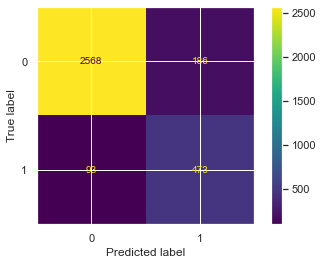

In [359]:
ConfusionMatrixDisplay.from_predictions(y_test.astype(int), preds_arbol)

In [262]:
print(classification_report(y_test.astype(int), preds_arbol))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2754
           1       0.73      0.81      0.77       566

    accuracy                           0.92      3320
   macro avg       0.84      0.88      0.86      3320
weighted avg       0.92      0.92      0.92      3320



<AxesSubplot:>

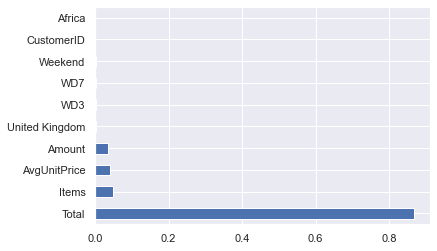

In [263]:
#Plot feature importance
%matplotlib inline
feature_importances = pd.Series(best_arbol.feature_importances_, index=Predictors)
feature_importances.nlargest(10).plot(kind='barh')

RANDOM FOREST

In [439]:
# Cantidad de arboles
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 300, num = 5)]
# Cantidad de features considerados en cada split
max_features = ['auto', 'sqrt']
# Maxima cantidad de profundidad de los arboles
max_depth = [int(x) for x in np.linspace(10, 200, num = 5)]
max_depth.append(None)
# Cantidad minima de smaples requeridos para partir un nodo
min_samples_split = [2, 5, 10, 25, 50]
# cantidad minima de samples requeridos por nodo hoja
min_samples_leaf = [1, 2, 4, 10, 20]
# Metodo de seleccion de los samples
bootstrap = [True]
#criterion
criterion=['gini', 'entropy', 'logloss']
#weights
class_weight=[{0:0.5,1:0.5}, {0:0.3,1:0.7}]
# Creo random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion,
               'class_weight': class_weight}

In [440]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv =5, verbose=2, random_state=42, n_jobs = -1)

In [441]:
rf_random.fit(X_train, y_train.astype(int))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END bootstrap=True, class_weight={0: 0.3, 1: 0.7}, criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=50, n_estimators=20; total time=   0.4s
[CV] END bootstrap=True, class_weight={0: 0.3, 1: 0.7}, criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=50, n_estimators=20; total time=   0.5s
[CV] END bootstrap=True, class_weight={0: 0.3, 1: 0.7}, criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=50, n_estimators=20; total time=   0.5s
[CV] END bootstrap=True, class_weight={0: 0.3, 1: 0.7}, criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=50, n_estimators=20; total time=   0.5s
[CV] END bootstrap=True, class_weight={0: 0.5, 1: 0.5}, criterion=gini, max_depth=152, max_features=auto, min_samples_leaf=20, min_samples_split=10, n_estimators=20; total time=   0.4s
[


105 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 86

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=60,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'class_weight': [{0: 0.5, 1: 0.5},
                                                         {0: 0.3, 1: 0.7}],
                                        'criterion': ['gini', 'entropy',
                                                      'logloss'],
                                        'max_depth': [10, 57, 105, 152, 200,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 10, 20],
                                        'min_samples_split': [2, 5, 10, 25, 50],
                                        'n_estimators': [20, 90, 160, 230,
                                                         300]},
                   random_state=42, 

In [442]:
rf_random.best_params_

{'n_estimators': 20,
 'min_samples_split': 10,
 'min_samples_leaf': 20,
 'max_features': 'auto',
 'max_depth': 152,
 'criterion': 'gini',
 'class_weight': {0: 0.5, 1: 0.5},
 'bootstrap': True}

In [443]:
best_random=rf_random.best_estimator_

In [444]:
preds_rf = best_random.predict(X_test)

In [445]:
accuracy_score(y_test.astype(int), preds_rf)

0.9246987951807228

In [340]:
roc_auc_score(y_test.astype(int), preds_rf)

0.8607710981264644

In [341]:
average_precision_score(y_test.astype(int), preds_rf)

0.6473163412551074

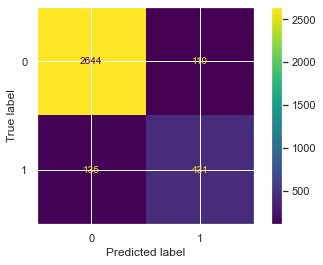

In [342]:
ConfusionMatrixDisplay.from_predictions(y_test.astype(int), preds_rf)

In [343]:
print(classification_report(y_test.astype(int), preds_rf))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2754
           1       0.80      0.76      0.78       566

    accuracy                           0.93      3320
   macro avg       0.87      0.86      0.87      3320
weighted avg       0.93      0.93      0.93      3320



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


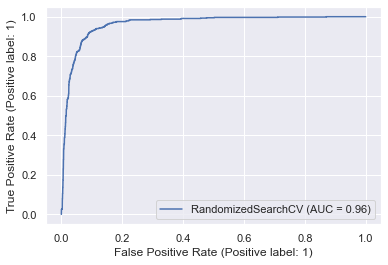

In [344]:
plot_roc_curve(rf_random, X_test, y_test.astype(int), drop_intermediate=True, response_method='auto', name=None, ax=None, pos_label=None)

In [345]:
precision_recall_fscore_support(y_test.astype(int), preds_rf, average='weighted')

(0.9250395440775674, 0.9262048192771084, 0.9255382563856727, None)

<AxesSubplot:>

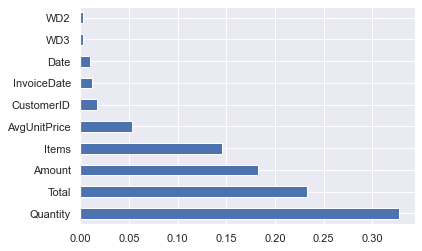

In [346]:
#Plot feature importance
%matplotlib inline
feature_importances = pd.Series(best_random.feature_importances_, index=Predictors)
feature_importances.nlargest(10).plot(kind='barh')

ADABOOST

In [321]:
#DTC=DecisionTreeClassifier(max_depth=10)
ada = AdaBoostClassifier(base_estimator=best_arbol)

In [322]:
ada_random_grid={'n_estimators':[int(x) for x in np.linspace(start = 20, stop = 300, num = 5)],
                'learning_rate':[.001,0.01,.1],
                'random_state':[42]}

ada_random=RandomizedSearchCV(estimator=ada,param_distributions=ada_random_grid,n_iter=60,cv=5,n_jobs=-1)

In [323]:
ada_random.fit(X_train,y_train.astype(int))
ada_random.best_params_

The total space of parameters 15 is smaller than n_iter=60. Running 15 iterations. For exhaustive searches, use GridSearchCV.


{'random_state': 42, 'n_estimators': 160, 'learning_rate': 0.001}

In [324]:
best_ada=ada_random.best_estimator_

In [325]:
ada_pred=best_ada.predict(X_test)

In [326]:
accuracy_score(y_test.astype(int), ada_pred)

0.9265060240963855

In [327]:
roc_auc_score(y_test.astype(int), ada_pred)

0.8777967671822032

In [328]:
average_precision_score(y_test.astype(int), ada_pred)

0.655489094185931

In [329]:
print(classification_report(y_test.astype(int), ada_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2754
           1       0.77      0.80      0.79       566

    accuracy                           0.93      3320
   macro avg       0.87      0.88      0.87      3320
weighted avg       0.93      0.93      0.93      3320



In [290]:
precision_recall_fscore_support(y_test.astype(int), ada_pred, average='weighted')

(0.9228091356126531, 0.925, 0.9235154164303596, None)

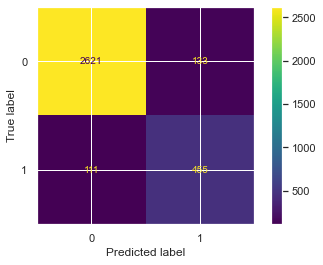

In [330]:
ConfusionMatrixDisplay.from_predictions(y_test.astype(int), ada_pred)

<AxesSubplot:>

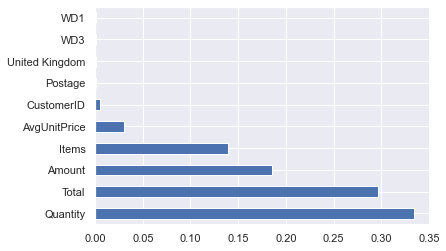

In [331]:
#Plot feature importance
%matplotlib inline
feature_importances = pd.Series(best_ada.feature_importances_, index=Predictors)
feature_importances.nlargest(10).plot(kind='barh')

LIGHT GBM

In [418]:
lgb_model = lgb.LGBMClassifier(random_state=42)

In [419]:
lgbm_random_grid = {
    'task' : ['train', 'predict'],
    'boosting': ['dart','gbdt'],
    'objective': ['huber','rmse'],
    'metric': ['mae'],
    'num_iterations': [ 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500],
    'learning_rate':[ 0.05, 0.005, 0.0005],
    'max_depth' :[ 10, 20, 40,60,80,100, 120],
    'min_data_in_leaf':[50,80,90, 100,110, 120 ],
   'feature_fraction': [ 0.5,0.6, 0.7, 0.8, 0.9],
    'bagging_fraction': [ 0.5, 0.6, 0.7, 0.8, 0.9 ],
    'bagging_freq': [ 3,5, 8, 10, 15, 20 ],
    'num_leaves': [ 50, 80, 100, 150, 180, 200],
    'max_bins': [100,150, 200, 250, 300],
    'reg_alpha': [0.5,1, 3, 5, 10],
    'reg_lambda': [0.5,1, 3, 5, 10],
     
 }

In [420]:
random_lgb = RandomizedSearchCV(estimator=lgb_model, param_distributions = lgbm_random_grid, n_iter=60,cv=5, verbose=2, random_state=42, n_jobs=-1)

In [421]:
random_lgb.fit(X_train,y_train.astype(int))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is 

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alia

[CV] END bagging_fraction=0.6, bagging_freq=3, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=150, max_depth=60, metric=mae, min_data_in_leaf=120, num_iterations=5500, num_leaves=150, objective=rmse, reg_alpha=10, reg_lambda=3, task=predict; total time=   7.8s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=20, boosting=gbdt, feature_fraction=0.6, learning_rate=0.0005, max_bins=250, max_depth=20, metric=mae, min_data_in_leaf=110, num_iterations=4000, num_leaves=200, objective=huber, reg_alpha=1, reg_lambda=10, task=train; total time=  10.5s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=20, boosting=gbdt, feature_fraction=0.6, learning_rate=0.0005, max_bins=250, max_depth=20, metric=mae, min_data_in_leaf=110, num_iterations=4000, num_leaves=200, objective=huber, reg_alpha=1, reg_lambda=10, task=train; total time=  10.8s
[CV] END bagging_fraction=0.7, bagging_freq=20, boosting=gbdt, feature_fraction=0.6, learning_rate=0.0005, max_bins=250, max_depth=20, metric=mae, min_data_in_leaf=110, num_iterations=4000, num_leaves=200, objective=huber, reg_alpha=1, reg_lambda=10, task=train; total time=  10.9s
[CV] END bagging_fraction=0.6, bagging_freq=3, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=150, max_depth=60, metric=mae, min_data_in_leaf=120, num_iterations=5500, num_leaves=150, objective=rmse, reg_alpha=10, reg_lambda=3, task=predict; total time=  10.9s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alia

[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV] END bagging_fraction=0.6, bagging_freq=3, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=150, max_depth=60, metric=mae, min_data_in_leaf=120, num_iterations=5500, num_leaves=150, objective=rmse, reg_alpha=10, reg_lambda=3, task=predict; total time=  11.1s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is se

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=3, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=150, max_depth=60, metric=mae, min_data_in_leaf=120, num_iterations=5500, num_leaves=150, objective=rmse, reg_alpha=10, reg_lambda=3, task=predict; total time=   9.3s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=3, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=150, max_depth=60, metric=mae, min_data_in_leaf=120, num_iterations=5500, num_leaves=150, objective=rmse, reg_alpha=10, reg_lambda=3, task=predict; total time=   8.7s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=15, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=150, max_depth=10, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=50, objective=huber, reg_alpha=0.5, reg_lambda=3, task=train; total time=  11.1s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=15, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=150, max_depth=10, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=50, objective=huber, reg_alpha=0.5, reg_lambda=3, task=train; total time=  11.2s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV] END bagging_fraction=0.9, bagging_freq=15, boosting=gbdt, feature_fraction=0.5, learn

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=15, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=150, max_depth=10, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=50, objective=huber, reg_alpha=0.5, reg_lambda=3, task=train; total time=  11.7s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[CV] END bagging_fraction=0.9, bagging_freq=15, boosting=gbdt, feature_fraction=0.5, lea

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=15, boosting=dart, feature_fraction=0.7, learning_rate=0.05, max_bins=200, max_depth=60, metric=mae, min_data_in_leaf=120, num_iterations=2000, num_leaves=100, objective=rmse, reg_alpha=1, reg_lambda=1, task=predict; total time= 7.2min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=15, boosting=dart, feature_fraction=0.7, learning_rate=0.05, max_bins=200, max_depth=60, metric=mae, min_data_in_leaf=120, num_iterations=2000, num_leaves=100, objective=rmse, reg_alpha=1, reg_lambda=1, task=predict; total time= 7.2min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=15, boosting=dart, feature_fraction=0.7, learning_rate=0.05, max_bins=200, max_depth=60, metric=mae, min_data_in_leaf=120, num_iterations=2000, num_leaves=100, objective=rmse, reg_alpha=1, reg_lambda=1, task=predict; total time= 7.2min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=150, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=2000, num_leaves=200, objective=rmse, reg_alpha=3, reg_lambda=1, task=train; total time= 2.8min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=15, boosting=dart, feature_fraction=0.7, learning_rate=0.05, max_bins=200, max_depth=60, metric=mae, min_data_in_leaf=120, num_iterations=2000, num_leaves=100, objective=rmse, reg_alpha=1, reg_lambda=1, task=predict; total time= 3.0min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=15, boosting=dart, feature_fraction=0.7, learning_rate=0.05, max_bins=200, max_depth=60, metric=mae, min_data_in_leaf=120, num_iterations=2000, num_leaves=100, objective=rmse, reg_alpha=1, reg_lambda=1, task=predict; total time= 3.1min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=110, num_iterations=4500, num_leaves=100, objective=huber, reg_alpha=1, reg_lambda=3, task=train; total time=11.2min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=110, num_iterations=4500, num_leaves=100, objective=huber, reg_alpha=1, reg_lambda=3, task=train; total time=11.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=110, num_iterations=4500, num_leaves=100, objective=huber, reg_alpha=1, reg_lambda=3, task=train; total time=11.6min


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV] END bagging_fraction=0.7, bagging_freq=5, boosting=gbdt, feature_fraction=0.7, learning_rate=0.005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=90, num_iterations=2000, num_leaves=100, objective=rmse, reg_alpha=3, reg_lambda=5, task=train; total time=  11.1s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, su

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=110, num_iterations=4500, num_leaves=100, objective=huber, reg_alpha=1, reg_lambda=3, task=train; total time=11.7min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=5, boosting=gbdt, feature_fraction=0.7, learning_rate=0.005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=90, num_iterations=2000, num_leaves=100, objective=rmse, reg_alpha=3, reg_lambda=5, task=train; total time=  11.0s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=110, num_iterations=4500, num_leaves=100, objective=huber, reg_alpha=1, reg_lambda=3, task=train; total time=11.8min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=5, boosting=gbdt, feature_fraction=0.7, learning_rate=0.005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=90, num_iterations=2000, num_leaves=100, objective=rmse, reg_alpha=3, reg_lambda=5, task=train; total time=  10.5s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=5, boosting=gbdt, feature_fraction=0.7, learning_rate=0.005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=90, num_iterations=2000, num_leaves=100, objective=rmse, reg_alpha=3, reg_lambda=5, task=train; total time=  10.6s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=5, boosting=gbdt, feature_fraction=0.7, learning_rate=0.005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=90, num_iterations=2000, num_leaves=100, objective=rmse, reg_alpha=3, reg_lambda=5, task=train; total time=  11.5s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=150, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=2000, num_leaves=200, objective=rmse, reg_alpha=3, reg_lambda=1, task=train; total time= 3.2min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=150, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=2000, num_leaves=200, objective=rmse, reg_alpha=3, reg_lambda=1, task=train; total time= 3.1min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=150, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=2000, num_leaves=200, objective=rmse, reg_alpha=3, reg_lambda=1, task=train; total time= 3.2min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=10, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=200, max_depth=10, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=100, objective=rmse, reg_alpha=5, reg_lambda=10, task=predict; total time=   9.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=10, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=200, max_depth=10, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=100, objective=rmse, reg_alpha=5, reg_lambda=10, task=predict; total time=   9.6s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=10, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=200, max_depth=10, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=100, objective=rmse, reg_alpha=5, reg_lambda=10, task=predict; total time=   9.1s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=10, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=200, max_depth=10, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=100, objective=rmse, reg_alpha=5, reg_lambda=10, task=predict; total time=   9.2s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=10, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=200, max_depth=10, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=100, objective=rmse, reg_alpha=5, reg_lambda=10, task=predict; total time=   8.9s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=150, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=2000, num_leaves=200, objective=rmse, reg_alpha=3, reg_lambda=1, task=train; total time= 3.0min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=15, boosting=dart, feature_fraction=0.6, learning_rate=0.005, max_bins=250, max_depth=120, metric=mae, min_data_in_leaf=80, num_iterations=2000, num_leaves=200, objective=rmse, reg_alpha=0.5, reg_lambda=0.5, task=train; total time= 3.7min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=15, boosting=dart, feature_fraction=0.6, learning_rate=0.005, max_bins=250, max_depth=120, metric=mae, min_data_in_leaf=80, num_iterations=2000, num_leaves=200, objective=rmse, reg_alpha=0.5, reg_lambda=0.5, task=train; total time= 3.8min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=15, boosting=dart, feature_fraction=0.6, learning_rate=0.005, max_bins=250, max_depth=120, metric=mae, min_data_in_leaf=80, num_iterations=2000, num_leaves=200, objective=rmse, reg_alpha=0.5, reg_lambda=0.5, task=train; total time= 3.7min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=15, boosting=dart, feature_fraction=0.6, learning_rate=0.005, max_bins=250, max_depth=120, metric=mae, min_data_in_leaf=80, num_iterations=2000, num_leaves=200, objective=rmse, reg_alpha=0.5, reg_lambda=0.5, task=train; total time= 3.8min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=15, boosting=dart, feature_fraction=0.6, learning_rate=0.005, max_bins=250, max_depth=120, metric=mae, min_data_in_leaf=80, num_iterations=2000, num_leaves=200, objective=rmse, reg_alpha=0.5, reg_lambda=0.5, task=train; total time= 3.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=8, boosting=dart, feature_fraction=0.6, learning_rate=0.0005, max_bins=300, max_depth=120, metric=mae, min_data_in_leaf=90, num_iterations=2000, num_leaves=100, objective=huber, reg_alpha=1, reg_lambda=3, task=train; total time= 2.5min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=8, boosting=dart, feature_fraction=0.6, learning_rate=0.0005, max_bins=300, max_depth=120, metric=mae, min_data_in_leaf=90, num_iterations=2000, num_leaves=100, objective=huber, reg_alpha=1, reg_lambda=3, task=train; total time= 2.5min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=15, boosting=dart, feature_fraction=0.6, learning_rate=0.005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=100, num_iterations=4000, num_leaves=80, objective=rmse, reg_alpha=3, reg_lambda=10, task=train; total time= 5.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=15, boosting=dart, feature_fraction=0.6, learning_rate=0.005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=100, num_iterations=4000, num_leaves=80, objective=rmse, reg_alpha=3, reg_lambda=10, task=train; total time= 5.4min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=15, boosting=dart, feature_fraction=0.6, learning_rate=0.005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=100, num_iterations=4000, num_leaves=80, objective=rmse, reg_alpha=3, reg_lambda=10, task=train; total time= 5.0min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=8, boosting=dart, feature_fraction=0.6, learning_rate=0.0005, max_bins=300, max_depth=120, metric=mae, min_data_in_leaf=90, num_iterations=2000, num_leaves=100, objective=huber, reg_alpha=1, reg_lambda=3, task=train; total time= 2.4min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=8, boosting=dart, feature_fraction=0.6, learning_rate=0.0005, max_bins=300, max_depth=120, metric=mae, min_data_in_leaf=90, num_iterations=2000, num_leaves=100, objective=huber, reg_alpha=1, reg_lambda=3, task=train; total time= 2.5min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=15, boosting=dart, feature_fraction=0.6, learning_rate=0.005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=100, num_iterations=4000, num_leaves=80, objective=rmse, reg_alpha=3, reg_lambda=10, task=train; total time= 5.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=8, boosting=dart, feature_fraction=0.6, learning_rate=0.0005, max_bins=300, max_depth=120, metric=mae, min_data_in_leaf=90, num_iterations=2000, num_leaves=100, objective=huber, reg_alpha=1, reg_lambda=3, task=train; total time= 2.5min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=15, boosting=dart, feature_fraction=0.6, learning_rate=0.005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=100, num_iterations=4000, num_leaves=80, objective=rmse, reg_alpha=3, reg_lambda=10, task=train; total time= 5.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=20, boosting=gbdt, feature_fraction=0.7, learning_rate=0.05, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=90, num_iterations=4500, num_leaves=200, objective=huber, reg_alpha=5, reg_lambda=0.5, task=train; total time=   9.0s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=20, boosting=gbdt, feature_fraction=0.7, learning_rate=0.05, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=90, num_iterations=4500, num_leaves=200, objective=huber, reg_alpha=5, reg_lambda=0.5, task=train; total time=   9.8s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=20, boosting=gbdt, feature_fraction=0.7, learning_rate=0.05, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=90, num_iterations=4500, num_leaves=200, objective=huber, reg_alpha=5, reg_lambda=0.5, task=train; total time=   8.8s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=20, boosting=gbdt, feature_fraction=0.7, learning_rate=0.05, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=90, num_iterations=4500, num_leaves=200, objective=huber, reg_alpha=5, reg_lambda=0.5, task=train; total time=  12.5s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=20, boosting=gbdt, feature_fraction=0.7, learning_rate=0.05, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=90, num_iterations=4500, num_leaves=200, objective=huber, reg_alpha=5, reg_lambda=0.5, task=train; total time=  11.8s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=100, max_depth=10, metric=mae, min_data_in_leaf=90, num_iterations=4500, num_leaves=80, objective=rmse, reg_alpha=0.5, reg_lambda=10, task=predict; total time=  26.8s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=100, max_depth=10, metric=mae, min_data_in_leaf=90, num_iterations=4500, num_leaves=80, objective=rmse, reg_alpha=0.5, reg_lambda=10, task=predict; total time=  27.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=100, max_depth=10, metric=mae, min_data_in_leaf=90, num_iterations=4500, num_leaves=80, objective=rmse, reg_alpha=0.5, reg_lambda=10, task=predict; total time=  26.8s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=20, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=100, num_iterations=2500, num_leaves=150, objective=huber, reg_alpha=10, reg_lambda=10, task=train; total time=   4.7s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=20, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=100, num_iterations=2500, num_leaves=150, objective=huber, reg_alpha=10, reg_lambda=10, task=train; total time=   4.6s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=20, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=100, num_iterations=2500, num_leaves=150, objective=huber, reg_alpha=10, reg_lambda=10, task=train; total time=   4.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=20, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=100, num_iterations=2500, num_leaves=150, objective=huber, reg_alpha=10, reg_lambda=10, task=train; total time=   4.7s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=100, max_depth=10, metric=mae, min_data_in_leaf=90, num_iterations=4500, num_leaves=80, objective=rmse, reg_alpha=0.5, reg_lambda=10, task=predict; total time=  29.9s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=20, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=100, num_iterations=2500, num_leaves=150, objective=huber, reg_alpha=10, reg_lambda=10, task=train; total time=   4.8s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=100, max_depth=10, metric=mae, min_data_in_leaf=90, num_iterations=4500, num_leaves=80, objective=rmse, reg_alpha=0.5, reg_lambda=10, task=predict; total time=  30.0s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=8, boosting=dart, feature_fraction=0.7, learning_rate=0.005, max_bins=200, max_depth=60, metric=mae, min_data_in_leaf=50, num_iterations=3000, num_leaves=180, objective=huber, reg_alpha=1, reg_lambda=0.5, task=train; total time= 5.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=8, boosting=dart, feature_fraction=0.7, learning_rate=0.005, max_bins=200, max_depth=60, metric=mae, min_data_in_leaf=50, num_iterations=3000, num_leaves=180, objective=huber, reg_alpha=1, reg_lambda=0.5, task=train; total time= 5.1min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=8, boosting=dart, feature_fraction=0.7, learning_rate=0.005, max_bins=200, max_depth=60, metric=mae, min_data_in_leaf=50, num_iterations=3000, num_leaves=180, objective=huber, reg_alpha=1, reg_lambda=0.5, task=train; total time= 5.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=8, boosting=dart, feature_fraction=0.7, learning_rate=0.005, max_bins=200, max_depth=60, metric=mae, min_data_in_leaf=50, num_iterations=3000, num_leaves=180, objective=huber, reg_alpha=1, reg_lambda=0.5, task=train; total time= 5.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=8, boosting=dart, feature_fraction=0.8, learning_rate=0.005, max_bins=300, max_depth=20, metric=mae, min_data_in_leaf=90, num_iterations=2500, num_leaves=100, objective=rmse, reg_alpha=1, reg_lambda=5, task=predict; total time= 3.9min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=8, boosting=dart, feature_fraction=0.8, learning_rate=0.005, max_bins=300, max_depth=20, metric=mae, min_data_in_leaf=90, num_iterations=2500, num_leaves=100, objective=rmse, reg_alpha=1, reg_lambda=5, task=predict; total time= 3.9min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=8, boosting=dart, feature_fraction=0.8, learning_rate=0.005, max_bins=300, max_depth=20, metric=mae, min_data_in_leaf=90, num_iterations=2500, num_leaves=100, objective=rmse, reg_alpha=1, reg_lambda=5, task=predict; total time= 3.9min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] END bagging_fraction=0.6, bagging_freq=8, boosting=dart, feature_fraction=0.7, learnin

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=8, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=250, max_depth=80, metric=mae, min_data_in_leaf=120, num_iterations=2000, num_leaves=100, objective=rmse, reg_alpha=10, reg_lambda=3, task=predict; total time= 1.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=20, boosting=gbdt, feature_fraction=0.5, learning_rate=0.005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=2500, num_leaves=150, objective=huber, reg_alpha=1, reg_lambda=10, task=predict; total time=  21.3s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=8, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=250, max_depth=80, metric=mae, min_data_in_leaf=120, num_iterations=2000, num_leaves=100, objective=rmse, reg_alpha=10, reg_lambda=3, task=predict; total time= 1.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=20, boosting=gbdt, feature_fraction=0.5, learning_rate=0.005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=2500, num_leaves=150, objective=huber, reg_alpha=1, reg_lambda=10, task=predict; total time=  22.1s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=20, boosting=gbdt, feature_fraction=0.5, learning_rate=0.005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=2500, num_leaves=150, objective=huber, reg_alpha=1, reg_lambda=10, task=predict; total time=  22.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=20, boosting=gbdt, feature_fraction=0.5, learning_rate=0.005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=2500, num_leaves=150, objective=huber, reg_alpha=1, reg_lambda=10, task=predict; total time=  22.6s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=20, boosting=gbdt, feature_fraction=0.5, learning_rate=0.005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=2500, num_leaves=150, objective=huber, reg_alpha=1, reg_lambda=10, task=predict; total time=  21.9s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=8, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=250, max_depth=80, metric=mae, min_data_in_leaf=120, num_iterations=2000, num_leaves=100, objective=rmse, reg_alpha=10, reg_lambda=3, task=predict; total time= 1.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=8, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=250, max_depth=80, metric=mae, min_data_in_leaf=120, num_iterations=2000, num_leaves=100, objective=rmse, reg_alpha=10, reg_lambda=3, task=predict; total time= 1.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=8, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=250, max_depth=80, metric=mae, min_data_in_leaf=120, num_iterations=2000, num_leaves=100, objective=rmse, reg_alpha=10, reg_lambda=3, task=predict; total time= 1.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=8, boosting=gbdt, feature_fraction=0.9, learning_rate=0.05, max_bins=250, max_depth=60, metric=mae, min_data_in_leaf=110, num_iterations=4500, num_leaves=150, objective=huber, reg_alpha=10, reg_lambda=10, task=predict; total time=   6.8s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=8, boosting=gbdt, feature_fraction=0.9, learning_rate=0.05, max_bins=250, max_depth=60, metric=mae, min_data_in_leaf=110, num_iterations=4500, num_leaves=150, objective=huber, reg_alpha=10, reg_lambda=10, task=predict; total time=   7.0s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=8, boosting=dart, feature_fraction=0.8, learning_rate=0.005, max_bins=300, max_depth=20, metric=mae, min_data_in_leaf=90, num_iterations=2500, num_leaves=100, objective=rmse, reg_alpha=1, reg_lambda=5, task=predict; total time= 3.5min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=8, boosting=gbdt, feature_fraction=0.9, learning_rate=0.05, max_bins=250, max_depth=60, metric=mae, min_data_in_leaf=110, num_iterations=4500, num_leaves=150, objective=huber, reg_alpha=10, reg_lambda=10, task=predict; total time=   5.5s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=8, boosting=gbdt, feature_fraction=0.9, learning_rate=0.05, max_bins=250, max_depth=60, metric=mae, min_data_in_leaf=110, num_iterations=4500, num_leaves=150, objective=huber, reg_alpha=10, reg_lambda=10, task=predict; total time=   4.5s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=8, boosting=gbdt, feature_fraction=0.9, learning_rate=0.05, max_bins=250, max_depth=60, metric=mae, min_data_in_leaf=110, num_iterations=4500, num_leaves=150, objective=huber, reg_alpha=10, reg_lambda=10, task=predict; total time=   4.5s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=8, boosting=dart, feature_fraction=0.8, learning_rate=0.005, max_bins=300, max_depth=20, metric=mae, min_data_in_leaf=90, num_iterations=2500, num_leaves=100, objective=rmse, reg_alpha=1, reg_lambda=5, task=predict; total time= 3.8min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=150, max_depth=100, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=180, objective=rmse, reg_alpha=3, reg_lambda=5, task=train; total time= 3.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=150, max_depth=100, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=180, objective=rmse, reg_alpha=3, reg_lambda=5, task=train; total time= 3.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=150, max_depth=100, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=180, objective=rmse, reg_alpha=3, reg_lambda=5, task=train; total time= 3.5min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=20, boosting=gbdt, feature_fraction=0.7, learning_rate=0.05, max_bins=150, max_depth=40, metric=mae, min_data_in_leaf=110, num_iterations=3500, num_leaves=100, objective=huber, reg_alpha=3, reg_lambda=5, task=predict; total time=  15.2s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=20, boosting=gbdt, feature_fraction=0.7, learning_rate=0.05, max_bins=150, max_depth=40, metric=mae, min_data_in_leaf=110, num_iterations=3500, num_leaves=100, objective=huber, reg_alpha=3, reg_lambda=5, task=predict; total time=  17.3s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=20, boosting=gbdt, feature_fraction=0.7, learning_rate=0.05, max_bins=150, max_depth=40, metric=mae, min_data_in_leaf=110, num_iterations=3500, num_leaves=100, objective=huber, reg_alpha=3, reg_lambda=5, task=predict; total time=  14.7s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=20, boosting=gbdt, feature_fraction=0.7, learning_rate=0.05, max_bins=150, max_depth=40, metric=mae, min_data_in_leaf=110, num_iterations=3500, num_leaves=100, objective=huber, reg_alpha=3, reg_lambda=5, task=predict; total time=  14.2s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=20, boosting=gbdt, feature_fraction=0.7, learning_rate=0.05, max_bins=150, max_depth=40, metric=mae, min_data_in_leaf=110, num_iterations=3500, num_leaves=100, objective=huber, reg_alpha=3, reg_lambda=5, task=predict; total time=  14.2s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=8, boosting=gbdt, feature_fraction=0.7, learning_rate=0.0005, max_bins=200, max_depth=10, metric=mae, min_data_in_leaf=50, num_iterations=2000, num_leaves=200, objective=huber, reg_alpha=10, reg_lambda=0.5, task=predict; total time=   4.7s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=8, boosting=gbdt, feature_fraction=0.7, learning_rate=0.0005, max_bins=200, max_depth=10, metric=mae, min_data_in_leaf=50, num_iterations=2000, num_leaves=200, objective=huber, reg_alpha=10, reg_lambda=0.5, task=predict; total time=   4.6s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=8, boosting=gbdt, feature_fraction=0.7, learning_rate=0.0005, max_bins=200, max_depth=10, metric=mae, min_data_in_leaf=50, num_iterations=2000, num_leaves=200, objective=huber, reg_alpha=10, reg_lambda=0.5, task=predict; total time=   4.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=8, boosting=gbdt, feature_fraction=0.7, learning_rate=0.0005, max_bins=200, max_depth=10, metric=mae, min_data_in_leaf=50, num_iterations=2000, num_leaves=200, objective=huber, reg_alpha=10, reg_lambda=0.5, task=predict; total time=   4.5s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=8, boosting=gbdt, feature_fraction=0.7, learning_rate=0.0005, max_bins=200, max_depth=10, metric=mae, min_data_in_leaf=50, num_iterations=2000, num_leaves=200, objective=huber, reg_alpha=10, reg_lambda=0.5, task=predict; total time=   4.7s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=150, max_depth=100, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=180, objective=rmse, reg_alpha=3, reg_lambda=5, task=train; total time= 3.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=150, max_depth=100, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=180, objective=rmse, reg_alpha=3, reg_lambda=5, task=train; total time= 3.5min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=10, boosting=dart, feature_fraction=0.9, learning_rate=0.05, max_bins=300, max_depth=80, metric=mae, min_data_in_leaf=50, num_iterations=4500, num_leaves=180, objective=rmse, reg_alpha=0.5, reg_lambda=10, task=train; total time=13.4min


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[CV] END bagging_fraction=0.8, bagging_freq=10, boosting=dart, feature_fraction=0.9, learning_rate=0.05, max_bins=300, max_depth=80, metric=mae, min_data_in_leaf=50, num_iterations=4500, num_leaves=180, objective=rmse, reg_alpha=0.5, reg_lambda=10, task=train; total time=13.4min


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[CV] END bagging_fraction=0.8, bagging_freq=10, boosting=dart, feature_fraction=0.9, learning_rate=0.05, max_bins=300, max_depth=80, metric=mae, min_data_in_leaf=50, num_iterations=4500, num_leaves=180, objective=rmse, reg_alpha=0.5, reg_lambda=10, task=train; total time=13.5min


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV] END bagging_fraction=0.9, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=250, max_depth=80, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=180, objective=rmse, reg_alpha=5, reg_lambda=5, task=predict; total time=   9.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=250, max_depth=80, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=180, objective=rmse, reg_alpha=5, reg_lambda=5, task=predict; total time=   9.5s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=250, max_depth=80, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=180, objective=rmse, reg_alpha=5, reg_lambda=5, task=predict; total time=  10.2s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=10, boosting=dart, feature_fraction=0.9, learning_rate=0.05, max_bins=300, max_depth=80, metric=mae, min_data_in_leaf=50, num_iterations=4500, num_leaves=180, objective=rmse, reg_alpha=0.5, reg_lambda=10, task=train; total time=13.5min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=250, max_depth=80, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=180, objective=rmse, reg_alpha=5, reg_lambda=5, task=predict; total time=   9.8s
[CV] END bagging_fraction=0.8, bagging_freq=10, boosting=dart, feature_fraction=0.9, learning_rate=0.05, max_bins=300, max_depth=80, metric=mae, min_data_in_leaf=50, num_iterations=4500, num_leaves=180, objective=rmse, reg_alpha=0.5, reg_lambda=10, task=train; total time=13.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5, cols

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=250, max_depth=80, metric=mae, min_data_in_leaf=110, num_iterations=2500, num_leaves=180, objective=rmse, reg_alpha=5, reg_lambda=5, task=predict; total time=   9.9s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV] END bagging_fraction=0.5, bagging_freq=3, boosting=dart, feature_fraction=0.6, learning_rate=0.05, max_bins=150, max_depth=80, metric=mae, min_data_in_leaf=50, num_iterations=5000, num_leaves=150, objective=rmse, reg_alpha=1, reg_lambda=10, task=predict; total time=10.8min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, 

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=3, boosting=dart, feature_fraction=0.6, learning_rate=0.05, max_bins=150, max_depth=80, metric=mae, min_data_in_leaf=50, num_iterations=5000, num_leaves=150, objective=rmse, reg_alpha=1, reg_lambda=10, task=predict; total time=10.4min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=3, boosting=dart, feature_fraction=0.6, learning_rate=0.05, max_bins=150, max_depth=80, metric=mae, min_data_in_leaf=50, num_iterations=5000, num_leaves=150, objective=rmse, reg_alpha=1, reg_lambda=10, task=predict; total time=10.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.6, learning_rate=0.0005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=4500, num_leaves=100, objective=huber, reg_alpha=5, reg_lambda=1, task=train; total time=  11.6s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.6, learning_rate=0.0005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=4500, num_leaves=100, objective=huber, reg_alpha=5, reg_lambda=1, task=train; total time=  11.1s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.6, learning_rate=0.0005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=4500, num_leaves=100, objective=huber, reg_alpha=5, reg_lambda=1, task=train; total time=  12.3s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.6, learning_rate=0.0005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=4500, num_leaves=100, objective=huber, reg_alpha=5, reg_lambda=1, task=train; total time=  11.9s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.005, max_bins=200, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=4000, num_leaves=150, objective=rmse, reg_alpha=3, reg_lambda=1, task=train; total time= 5.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.005, max_bins=200, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=4000, num_leaves=150, objective=rmse, reg_alpha=3, reg_lambda=1, task=train; total time= 5.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.6, learning_rate=0.0005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=4500, num_leaves=100, objective=huber, reg_alpha=5, reg_lambda=1, task=train; total time=  12.1s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.005, max_bins=200, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=4000, num_leaves=150, objective=rmse, reg_alpha=3, reg_lambda=1, task=train; total time= 5.4min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=5, boosting=gbdt, feature_fraction=0.7, learning_rate=0.05, max_bins=100, max_depth=80, metric=mae, min_data_in_leaf=80, num_iterations=2500, num_leaves=50, objective=rmse, reg_alpha=0.5, reg_lambda=0.5, task=predict; total time=  16.7s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=5, boosting=gbdt, feature_fraction=0.7, learning_rate=0.05, max_bins=100, max_depth=80, metric=mae, min_data_in_leaf=80, num_iterations=2500, num_leaves=50, objective=rmse, reg_alpha=0.5, reg_lambda=0.5, task=predict; total time=  16.7s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=5, boosting=gbdt, feature_fraction=0.7, learning_rate=0.05, max_bins=100, max_depth=80, metric=mae, min_data_in_leaf=80, num_iterations=2500, num_leaves=50, objective=rmse, reg_alpha=0.5, reg_lambda=0.5, task=predict; total time=  17.0s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=5, boosting=gbdt, feature_fraction=0.7, learning_rate=0.05, max_bins=100, max_depth=80, metric=mae, min_data_in_leaf=80, num_iterations=2500, num_leaves=50, objective=rmse, reg_alpha=0.5, reg_lambda=0.5, task=predict; total time=  17.2s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=5, boosting=gbdt, feature_fraction=0.7, learning_rate=0.05, max_bins=100, max_depth=80, metric=mae, min_data_in_leaf=80, num_iterations=2500, num_leaves=50, objective=rmse, reg_alpha=0.5, reg_lambda=0.5, task=predict; total time=  17.0s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_bins=250, max_depth=80, metric=mae, min_data_in_leaf=120, num_iterations=4000, num_leaves=100, objective=rmse, reg_alpha=5, reg_lambda=0.5, task=predict; total time=  16.2s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_bins=250, max_depth=80, metric=mae, min_data_in_leaf=120, num_iterations=4000, num_leaves=100, objective=rmse, reg_alpha=5, reg_lambda=0.5, task=predict; total time=  17.0s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=gbdt, feature_fraction=0.8, 

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_bins=250, max_depth=80, metric=mae, min_data_in_leaf=120, num_iterations=4000, num_leaves=100, objective=rmse, reg_alpha=5, reg_lambda=0.5, task=predict; total time=  16.9s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[CV] END bagging_fraction=0.5, bagging_freq=10, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=200, max_depth=40, metric=mae, min_data_in_leaf=120, num_iterations=4500, num_leaves=100, objective=rmse, reg_alpha=5, reg_lambda=3, task=predict; total time=  12.8s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is se

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=10, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=200, max_depth=40, metric=mae, min_data_in_leaf=120, num_iterations=4500, num_leaves=100, objective=rmse, reg_alpha=5, reg_lambda=3, task=predict; total time=  12.9s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[CV] END bagging_fraction=0.5, bagging_freq=10, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=200, max_depth=40, metric=mae, min_data_in_leaf=120, num_iterations=4500, num_leaves=100, objective=rmse, reg_alpha=5, reg_lambda=3, task=predict; total time=  13.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[CV] END bagging_fraction=0.5, bagging_freq=10, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=200, max_depth=40, metric=mae, min_data_in_leaf=120, num_iterations=4500, num_leaves=100, objective=rmse, reg_alpha=5, reg_lambda=3, task=predict; total time=  13.5s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.005, max_bins=200, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=4000, num_leaves=150, objective=rmse, reg_alpha=3, reg_lambda=1, task=train; total time= 5.7min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.005, max_bins=200, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=4000, num_leaves=150, objective=rmse, reg_alpha=3, reg_lambda=1, task=train; total time= 5.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=3, boosting=dart, feature_fraction=0.6, learning_rate=0.05, max_bins=150, max_depth=80, metric=mae, min_data_in_leaf=50, num_iterations=5000, num_leaves=150, objective=rmse, reg_alpha=1, reg_lambda=10, task=predict; total time=10.4min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=3, boosting=dart, feature_fraction=0.6, learning_rate=0.05, max_bins=150, max_depth=80, metric=mae, min_data_in_leaf=50, num_iterations=5000, num_leaves=150, objective=rmse, reg_alpha=1, reg_lambda=10, task=predict; total time=10.5min


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV] END bagging_fraction=0.9, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_bins=150, max_depth=20, metric=mae, min_data_in_leaf=100, num_iterations=4500, num_leaves=80, objective=huber, reg_alpha=1, reg_lambda=3, task=predict; total time=  37.5s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV] END bagging_fraction=0.9, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_bins=150, max_depth=20, metric=mae, min_data_in_leaf=100, num_iterations=4500, num_leaves=80, objective=huber, reg_alpha=1, reg_lambda=3, task=predict; total time=  40.1s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV] END bagging_fraction=0.9, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_bins=150, max_depth=20, metric=mae, min_data_in_leaf=100, num_iterations=4500, num_leaves=80, objective=huber, reg_alpha=1, reg_lambda=3, task=predict; total time=  39.6s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[CV] END bagging_fraction=0.9, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_bins=150, max_depth=20, metric=mae, min_data_in_leaf=100, num_iterations=4500, num_leaves=80, objective=huber, reg_alpha=1, reg_lambda=3, task=predict; total time=  38.6s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_bins=150, max_depth=20, metric=mae, min_data_in_leaf=100, num_iterations=4500, num_leaves=80, objective=huber, reg_alpha=1, reg_lambda=3, task=predict; total time=  38.3s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=5, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=100, max_depth=60, metric=mae, min_data_in_leaf=110, num_iterations=5000, num_leaves=150, objective=rmse, reg_alpha=1, reg_lambda=3, task=train; total time= 8.9min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=5, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=100, max_depth=60, metric=mae, min_data_in_leaf=110, num_iterations=5000, num_leaves=150, objective=rmse, reg_alpha=1, reg_lambda=3, task=train; total time= 9.0min


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[CV] END bagging_fraction=0.5, bagging_freq=5, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=100, max_depth=60, metric=mae, min_data_in_leaf=110, num_iterations=5000, num_leaves=150, objective=rmse, reg_alpha=1, reg_lambda=3, task=train; total time= 9.0min


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[CV] END bagging_fraction=0.5, bagging_freq=5, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=100, max_depth=60, metric=mae, min_data_in_leaf=110, num_iterations=5000, num_leaves=150, objective=rmse, reg_alpha=1, reg_lambda=3, task=train; total time= 9.0min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=2

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=20, boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=100, num_iterations=2500, num_leaves=180, objective=huber, reg_alpha=0.5, reg_lambda=10, task=train; total time=  12.6s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=20, boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=100, num_iterations=2500, num_leaves=180, objective=huber, reg_alpha=0.5, reg_lambda=10, task=train; total time=  13.0s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=20, boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=100, num_iterations=2500, num_leaves=180, objective=huber, reg_alpha=0.5, reg_lambda=10, task=train; total time=  12.9s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=150, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=5500, num_leaves=80, objective=rmse, reg_alpha=3, reg_lambda=5, task=train; total time= 5.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=20, boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=100, num_iterations=2500, num_leaves=180, objective=huber, reg_alpha=0.5, reg_lambda=10, task=train; total time=  12.9s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=20, boosting=gbdt, feature_fraction=0.8, learning_rate=0.005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=100, num_iterations=2500, num_leaves=180, objective=huber, reg_alpha=0.5, reg_lambda=10, task=train; total time=  13.1s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=150, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=5500, num_leaves=80, objective=rmse, reg_alpha=3, reg_lambda=5, task=train; total time= 5.8min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=10, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=200, max_depth=100, metric=mae, min_data_in_leaf=100, num_iterations=5500, num_leaves=200, objective=rmse, reg_alpha=1, reg_lambda=1, task=train; total time=  28.2s
[CV] END bagging_fraction=0.5, bagging_freq=10, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=200, max_depth=100, metric=mae, min_data_in_leaf=100, num_iterations=5500, num_leaves=200, objective=rmse, reg_alpha=1, reg_lambda=1, task=train; total time=  29.0s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[CV] END bagging_fraction=0.5, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=150, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=5500, num_leaves=80, objective=rmse, reg_alpha=3, reg_lambda=5, task=train; total time= 5.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=10, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=200, max_depth=100, metric=mae, min_data_in_leaf=100, num_iterations=5500, num_leaves=200, objective=rmse, reg_alpha=1, reg_lambda=1, task=train; total time=  29.5s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=110, num_iterations=3000, num_leaves=80, objective=huber, reg_alpha=5, reg_lambda=10, task=train; total time=   6.1s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=110, num_iterations=3000, num_leaves=80, objective=huber, reg_alpha=5, reg_lambda=10, task=train; total time=   6.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=110, num_iterations=3000, num_leaves=80, objective=huber, reg_alpha=5, reg_lambda=10, task=train; total time=   5.8s
[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=110, num_iterations=3000, num_leaves=80, objective=huber, reg_alpha=5, reg_lambda=10, task=train; total time=   6.0s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=110, num_iterations=3000, num_leaves=80, objective=huber, reg_alpha=5, reg_lambda=10, task=train; total time=   6.7s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] END bagging_fraction=0.5, bagging_freq=10, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=200, max_depth=100, metric=mae, min_data_in_leaf=100, num_iterations=5500, num_leaves=200, objective=rmse, reg_alpha=1, reg_lambda=1, task=train; total time=  30.5s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] END bagging_fraction=0.5, bagging_freq=10, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=200, max_depth=100, metric=mae, min_data_in_leaf=100, num_iterations=5500, num_leaves=200, objective=rmse, reg_alpha=1, reg_lambda=1, task=train; total time=  30.8s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=5, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=100, max_depth=60, metric=mae, min_data_in_leaf=110, num_iterations=5000, num_leaves=150, objective=rmse, reg_alpha=1, reg_lambda=3, task=train; total time= 9.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=150, max_depth=100, metric=mae, min_data_in_leaf=110, num_iterations=5500, num_leaves=200, objective=rmse, reg_alpha=3, reg_lambda=5, task=predict; total time=  28.1s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=150, max_depth=100, metric=mae, min_data_in_leaf=110, num_iterations=5500, num_leaves=200, objective=rmse, reg_alpha=3, reg_lambda=5, task=predict; total time=  29.2s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] END bagging_fraction=0.8, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=200, max_depth=80, metric=mae, min_data_in_leaf=120, num_iterations=3000, num_leaves=150, objective=rmse, reg_alpha=10, reg_lambda=10, task=train; total time= 2.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is se

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=200, max_depth=80, metric=mae, min_data_in_leaf=120, num_iterations=3000, num_leaves=150, objective=rmse, reg_alpha=10, reg_lambda=10, task=train; total time= 2.7min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=200, max_depth=80, metric=mae, min_data_in_leaf=120, num_iterations=3000, num_leaves=150, objective=rmse, reg_alpha=10, reg_lambda=10, task=train; total time= 2.7min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=150, max_depth=100, metric=mae, min_data_in_leaf=110, num_iterations=5500, num_leaves=200, objective=rmse, reg_alpha=3, reg_lambda=5, task=predict; total time=  29.0s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=150, max_depth=100, metric=mae, min_data_in_leaf=110, num_iterations=5500, num_leaves=200, objective=rmse, reg_alpha=3, reg_lambda=5, task=predict; total time=  29.5s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=150, max_depth=100, metric=mae, min_data_in_leaf=110, num_iterations=5500, num_leaves=200, objective=rmse, reg_alpha=3, reg_lambda=5, task=predict; total time=  29.7s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[CV] END bagging_fraction=0.6, bagging_freq=3, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=300, max_depth=20, metric=mae, min_data_in_leaf=80, num_iterations=4500, num_leaves=200, objective=huber, reg_alpha=1, reg_lambda=10, task=predict; total time=  33.3s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3,

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=200, max_depth=80, metric=mae, min_data_in_leaf=120, num_iterations=3000, num_leaves=150, objective=rmse, reg_alpha=10, reg_lambda=10, task=train; total time= 3.4min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=200, max_depth=80, metric=mae, min_data_in_leaf=120, num_iterations=3000, num_leaves=150, objective=rmse, reg_alpha=10, reg_lambda=10, task=train; total time= 3.2min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=3, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=300, max_depth=20, metric=mae, min_data_in_leaf=80, num_iterations=4500, num_leaves=200, objective=huber, reg_alpha=1, reg_lambda=10, task=predict; total time=  34.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=20, boosting=gbdt, feature_fraction=0.9, learning_rate=0.0005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=3500, num_leaves=50, objective=rmse, reg_alpha=5, reg_lambda=1, task=predict; total time=   8.7s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=20, boosting=gbdt, feature_fraction=0.9, learning_rate=0.0005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=3500, num_leaves=50, objective=rmse, reg_alpha=5, reg_lambda=1, task=predict; total time=   8.7s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=20, boosting=gbdt, feature_fraction=0.9, learning_rate=0.0005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=3500, num_leaves=50, objective=rmse, reg_alpha=5, reg_lambda=1, task=predict; total time=   7.9s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=20, boosting=gbdt, feature_fraction=0.9, learning_rate=0.0005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=3500, num_leaves=50, objective=rmse, reg_alpha=5, reg_lambda=1, task=predict; total time=   8.8s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=3, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=300, max_depth=20, metric=mae, min_data_in_leaf=80, num_iterations=4500, num_leaves=200, objective=huber, reg_alpha=1, reg_lambda=10, task=predict; total time=  35.3s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=20, boosting=gbdt, feature_fraction=0.9, learning_rate=0.0005, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=50, num_iterations=3500, num_leaves=50, objective=rmse, reg_alpha=5, reg_lambda=1, task=predict; total time=   8.6s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=3, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=300, max_depth=20, metric=mae, min_data_in_leaf=80, num_iterations=4500, num_leaves=200, objective=huber, reg_alpha=1, reg_lambda=10, task=predict; total time=  33.8s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV] END bagging_fraction=0.6, bagging_freq=3, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=300, max_depth=20, metric=mae, min_data_in_leaf=80, num_iterations=4500, num_leaves=200, objective=huber, reg_alpha=1, reg_lambda=10, task=predict; total time=  34.8s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=300, max_depth=10, metric=mae, min_data_in_leaf=50, num_iterations=5000, num_leaves=150, objective=huber, reg_alpha=1, reg_lambda=10, task=predict; total time=  35.2s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=300, max_depth=10, metric=mae, min_data_in_leaf=50, num_iterations=5000, num_leaves=150, objective=huber, reg_alpha=1, reg_lambda=10, task=predict; total time=  38.2s
[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=300, max_depth=10, metric=mae, min_data_in_leaf=50, num_iterations=5000, num_leaves=150, objective=huber, reg_alpha=1, reg_lambda=10, task=predict; total time=  36.3s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7,

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=300, max_depth=10, metric=mae, min_data_in_leaf=50, num_iterations=5000, num_leaves=150, objective=huber, reg_alpha=1, reg_lambda=10, task=predict; total time=  37.6s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.5, learning_rate=0.05, max_bins=300, max_depth=10, metric=mae, min_data_in_leaf=50, num_iterations=5000, num_leaves=150, objective=huber, reg_alpha=1, reg_lambda=10, task=predict; total time=  34.9s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=3, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=100, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=3000, num_leaves=50, objective=rmse, reg_alpha=3, reg_lambda=5, task=predict; total time=   8.4s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV] END bagging_fraction=0.5, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=150, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=5500, num_leaves=80, objective=rmse, reg_alpha=3, reg_lambda=5, task=train; total time= 6.2min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, s

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=3, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=100, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=3000, num_leaves=50, objective=rmse, reg_alpha=3, reg_lambda=5, task=predict; total time=  11.3s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=3, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=100, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=3000, num_leaves=50, objective=rmse, reg_alpha=3, reg_lambda=5, task=predict; total time=   8.3s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=150, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=5500, num_leaves=80, objective=rmse, reg_alpha=3, reg_lambda=5, task=train; total time= 6.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=3, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=100, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=3000, num_leaves=50, objective=rmse, reg_alpha=3, reg_lambda=5, task=predict; total time=   8.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=3, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=100, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=3000, num_leaves=50, objective=rmse, reg_alpha=3, reg_lambda=5, task=predict; total time=   8.1s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=15, boosting=gbdt, feature_fraction=0.9, learning_rate=0.0005, max_bins=300, max_depth=40, metric=mae, min_data_in_leaf=110, num_iterations=5500, num_leaves=80, objective=rmse, reg_alpha=10, reg_lambda=10, task=train; total time=   9.3s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=15, boosting=gbdt, feature_fraction=0.9, learning_rate=0.0005, max_bins=300, max_depth=40, metric=mae, min_data_in_leaf=110, num_iterations=5500, num_leaves=80, objective=rmse, reg_alpha=10, reg_lambda=10, task=train; total time=   9.5s
[CV] END bagging_fraction=0.5, bagging_freq=15, boosting=gbdt, feature_fraction=0.9, learning_rate=0.0005, max_bins=300, max_depth=40, metric=mae, min_data_in_leaf=110, num_iterations=5500, num_leaves=80, objective=rmse, reg_alpha=10, reg_lambda=10, task=train; total time=   9.0s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8,

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[CV] END bagging_fraction=0.5, bagging_freq=15, boosting=gbdt, feature_fraction=0.9, learning_rate=0.0005, max_bins=300, max_depth=40, metric=mae, min_data_in_leaf=110, num_iterations=5500, num_leaves=80, objective=rmse, reg_alpha=10, reg_lambda=10, task=train; total time=   8.8s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is s

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=15, boosting=gbdt, feature_fraction=0.9, learning_rate=0.0005, max_bins=300, max_depth=40, metric=mae, min_data_in_leaf=110, num_iterations=5500, num_leaves=80, objective=rmse, reg_alpha=10, reg_lambda=10, task=train; total time=   9.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=200, max_depth=20, metric=mae, min_data_in_leaf=50, num_iterations=2000, num_leaves=50, objective=rmse, reg_alpha=1, reg_lambda=0.5, task=predict; total time=  11.9s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=200, max_depth=20, metric=mae, min_data_in_leaf=50, num_iterations=2000, num_leaves=50, objective=rmse, reg_alpha=1, reg_lambda=0.5, task=predict; total time=  11.7s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=200, max_depth=20, metric=mae, min_data_in_leaf=50, num_iterations=2000, num_leaves=50, objective=rmse, reg_alpha=1, reg_lambda=0.5, task=predict; total time=  11.3s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=200, max_depth=20, metric=mae, min_data_in_leaf=50, num_iterations=2000, num_leaves=50, objective=rmse, reg_alpha=1, reg_lambda=0.5, task=predict; total time=  11.1s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=15, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=200, max_depth=20, metric=mae, min_data_in_leaf=50, num_iterations=2000, num_leaves=50, objective=rmse, reg_alpha=1, reg_lambda=0.5, task=predict; total time=  11.1s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=15, boosting=dart, feature_fraction=0.8, learning_rate=0.005, max_bins=250, max_depth=120, metric=mae, min_data_in_leaf=100, num_iterations=2000, num_leaves=150, objective=rmse, reg_alpha=3, reg_lambda=0.5, task=train; total time= 2.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=15, boosting=dart, feature_fraction=0.8, learning_rate=0.005, max_bins=250, max_depth=120, metric=mae, min_data_in_leaf=100, num_iterations=2000, num_leaves=150, objective=rmse, reg_alpha=3, reg_lambda=0.5, task=train; total time= 2.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=15, boosting=dart, feature_fraction=0.8, learning_rate=0.005, max_bins=250, max_depth=120, metric=mae, min_data_in_leaf=100, num_iterations=2000, num_leaves=150, objective=rmse, reg_alpha=3, reg_lambda=0.5, task=train; total time= 2.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=20, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=100, max_depth=20, metric=mae, min_data_in_leaf=90, num_iterations=3000, num_leaves=100, objective=rmse, reg_alpha=1, reg_lambda=10, task=predict; total time= 4.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=20, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=100, max_depth=20, metric=mae, min_data_in_leaf=90, num_iterations=3000, num_leaves=100, objective=rmse, reg_alpha=1, reg_lambda=10, task=predict; total time= 4.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=20, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=100, max_depth=20, metric=mae, min_data_in_leaf=90, num_iterations=3000, num_leaves=100, objective=rmse, reg_alpha=1, reg_lambda=10, task=predict; total time= 4.3min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=3, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=200, max_depth=10, metric=mae, min_data_in_leaf=50, num_iterations=5500, num_leaves=200, objective=huber, reg_alpha=1, reg_lambda=3, task=predict; total time=  39.3s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=20, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=100, max_depth=20, metric=mae, min_data_in_leaf=90, num_iterations=3000, num_leaves=100, objective=rmse, reg_alpha=1, reg_lambda=10, task=predict; total time= 4.4min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=3, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=200, max_depth=10, metric=mae, min_data_in_leaf=50, num_iterations=5500, num_leaves=200, objective=huber, reg_alpha=1, reg_lambda=3, task=predict; total time=  42.0s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=3, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=200, max_depth=10, metric=mae, min_data_in_leaf=50, num_iterations=5500, num_leaves=200, objective=huber, reg_alpha=1, reg_lambda=3, task=predict; total time=  41.8s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=20, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=100, max_depth=20, metric=mae, min_data_in_leaf=90, num_iterations=3000, num_leaves=100, objective=rmse, reg_alpha=1, reg_lambda=10, task=predict; total time= 4.9min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=3, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=200, max_depth=10, metric=mae, min_data_in_leaf=50, num_iterations=5500, num_leaves=200, objective=huber, reg_alpha=1, reg_lambda=3, task=predict; total time=  43.0s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.8, bagging_freq=3, boosting=gbdt, feature_fraction=0.8, learning_rate=0.05, max_bins=200, max_depth=10, metric=mae, min_data_in_leaf=50, num_iterations=5500, num_leaves=200, objective=huber, reg_alpha=1, reg_lambda=3, task=predict; total time=  43.2s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=15, boosting=dart, feature_fraction=0.8, learning_rate=0.005, max_bins=250, max_depth=120, metric=mae, min_data_in_leaf=100, num_iterations=2000, num_leaves=150, objective=rmse, reg_alpha=3, reg_lambda=0.5, task=train; total time= 2.4min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=15, boosting=dart, feature_fraction=0.8, learning_rate=0.005, max_bins=250, max_depth=120, metric=mae, min_data_in_leaf=100, num_iterations=2000, num_leaves=150, objective=rmse, reg_alpha=3, reg_lambda=0.5, task=train; total time= 2.4min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=250, max_depth=20, metric=mae, min_data_in_leaf=110, num_iterations=5000, num_leaves=50, objective=huber, reg_alpha=5, reg_lambda=10, task=train; total time= 5.1min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=250, max_depth=20, metric=mae, min_data_in_leaf=110, num_iterations=5000, num_leaves=50, objective=huber, reg_alpha=5, reg_lambda=10, task=train; total time= 4.9min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=250, max_depth=20, metric=mae, min_data_in_leaf=110, num_iterations=5000, num_leaves=50, objective=huber, reg_alpha=5, reg_lambda=10, task=train; total time= 5.2min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=3, boosting=gbdt, feature_fraction=0.5, learning_rate=0.0005, max_bins=300, max_depth=80, metric=mae, min_data_in_leaf=80, num_iterations=2000, num_leaves=200, objective=rmse, reg_alpha=3, reg_lambda=10, task=train; total time=   4.5s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=3, boosting=gbdt, feature_fraction=0.5, learning_rate=0.0005, max_bins=300, max_depth=80, metric=mae, min_data_in_leaf=80, num_iterations=2000, num_leaves=200, objective=rmse, reg_alpha=3, reg_lambda=10, task=train; total time=   4.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=3, boosting=gbdt, feature_fraction=0.5, learning_rate=0.0005, max_bins=300, max_depth=80, metric=mae, min_data_in_leaf=80, num_iterations=2000, num_leaves=200, objective=rmse, reg_alpha=3, reg_lambda=10, task=train; total time=   4.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=5, boosting=dart, feature_fraction=0.6, learning_rate=0.05, max_bins=250, max_depth=100, metric=mae, min_data_in_leaf=120, num_iterations=2500, num_leaves=80, objective=rmse, reg_alpha=1, reg_lambda=5, task=predict; total time= 5.0min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=3, boosting=gbdt, feature_fraction=0.5, learning_rate=0.0005, max_bins=300, max_depth=80, metric=mae, min_data_in_leaf=80, num_iterations=2000, num_leaves=200, objective=rmse, reg_alpha=3, reg_lambda=10, task=train; total time=   4.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=3, boosting=gbdt, feature_fraction=0.5, learning_rate=0.0005, max_bins=300, max_depth=80, metric=mae, min_data_in_leaf=80, num_iterations=2000, num_leaves=200, objective=rmse, reg_alpha=3, reg_lambda=10, task=train; total time=   4.1s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=250, max_depth=20, metric=mae, min_data_in_leaf=110, num_iterations=5000, num_leaves=50, objective=huber, reg_alpha=5, reg_lambda=10, task=train; total time= 5.1min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=200, max_depth=20, metric=mae, min_data_in_leaf=100, num_iterations=2000, num_leaves=50, objective=huber, reg_alpha=5, reg_lambda=5, task=train; total time=   7.2s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=200, max_depth=20, metric=mae, min_data_in_leaf=100, num_iterations=2000, num_leaves=50, objective=huber, reg_alpha=5, reg_lambda=5, task=train; total time=   7.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=200, max_depth=20, metric=mae, min_data_in_leaf=100, num_iterations=2000, num_leaves=50, objective=huber, reg_alpha=5, reg_lambda=5, task=train; total time=   7.2s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=200, max_depth=20, metric=mae, min_data_in_leaf=100, num_iterations=2000, num_leaves=50, objective=huber, reg_alpha=5, reg_lambda=5, task=train; total time=   6.9s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=200, max_depth=20, metric=mae, min_data_in_leaf=100, num_iterations=2000, num_leaves=50, objective=huber, reg_alpha=5, reg_lambda=5, task=train; total time=   6.9s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=8, boosting=dart, feature_fraction=0.5, learning_rate=0.05, max_bins=250, max_depth=20, metric=mae, min_data_in_leaf=110, num_iterations=5000, num_leaves=50, objective=huber, reg_alpha=5, reg_lambda=10, task=train; total time= 5.5min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=5, boosting=dart, feature_fraction=0.6, learning_rate=0.05, max_bins=250, max_depth=100, metric=mae, min_data_in_leaf=120, num_iterations=2500, num_leaves=80, objective=rmse, reg_alpha=1, reg_lambda=5, task=predict; total time= 4.8min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=5, boosting=dart, feature_fraction=0.6, learning_rate=0.05, max_bins=250, max_depth=100, metric=mae, min_data_in_leaf=120, num_iterations=2500, num_leaves=80, objective=rmse, reg_alpha=1, reg_lambda=5, task=predict; total time= 4.9min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=5, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=150, max_depth=40, metric=mae, min_data_in_leaf=90, num_iterations=3500, num_leaves=150, objective=rmse, reg_alpha=5, reg_lambda=1, task=train; total time=  11.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=5, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=150, max_depth=40, metric=mae, min_data_in_leaf=90, num_iterations=3500, num_leaves=150, objective=rmse, reg_alpha=5, reg_lambda=1, task=train; total time=  11.0s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=5, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=150, max_depth=40, metric=mae, min_data_in_leaf=90, num_iterations=3500, num_leaves=150, objective=rmse, reg_alpha=5, reg_lambda=1, task=train; total time=  12.2s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=5, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=150, max_depth=40, metric=mae, min_data_in_leaf=90, num_iterations=3500, num_leaves=150, objective=rmse, reg_alpha=5, reg_lambda=1, task=train; total time=  12.1s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=5, boosting=gbdt, feature_fraction=0.6, learning_rate=0.05, max_bins=150, max_depth=40, metric=mae, min_data_in_leaf=90, num_iterations=3500, num_leaves=150, objective=rmse, reg_alpha=5, reg_lambda=1, task=train; total time=  11.0s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=5, boosting=dart, feature_fraction=0.6, learning_rate=0.05, max_bins=250, max_depth=100, metric=mae, min_data_in_leaf=120, num_iterations=2500, num_leaves=80, objective=rmse, reg_alpha=1, reg_lambda=5, task=predict; total time= 4.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=5, boosting=dart, feature_fraction=0.6, learning_rate=0.05, max_bins=250, max_depth=100, metric=mae, min_data_in_leaf=120, num_iterations=2500, num_leaves=80, objective=rmse, reg_alpha=1, reg_lambda=5, task=predict; total time= 4.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=3, boosting=dart, feature_fraction=0.7, learning_rate=0.05, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=90, num_iterations=3500, num_leaves=80, objective=huber, reg_alpha=10, reg_lambda=0.5, task=train; total time= 2.7min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=150, max_depth=20, metric=mae, min_data_in_leaf=80, num_iterations=4000, num_leaves=50, objective=huber, reg_alpha=1, reg_lambda=10, task=train; total time= 5.0min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=150, max_depth=20, metric=mae, min_data_in_leaf=80, num_iterations=4000, num_leaves=50, objective=huber, reg_alpha=1, reg_lambda=10, task=train; total time= 5.1min


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=150, max_depth=20, metric=mae, min_data_in_leaf=80, num_iterations=4000, num_leaves=50, objective=huber, reg_alpha=1, reg_lambda=10, task=train; total time= 5.1min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is se

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=150, max_depth=20, metric=mae, min_data_in_leaf=80, num_iterations=4000, num_leaves=50, objective=huber, reg_alpha=1, reg_lambda=10, task=train; total time= 5.1min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.7, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=150, max_depth=20, metric=mae, min_data_in_leaf=80, num_iterations=4000, num_leaves=50, objective=huber, reg_alpha=1, reg_lambda=10, task=train; total time= 5.8min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=3, boosting=dart, feature_fraction=0.7, learning_rate=0.05, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=90, num_iterations=3500, num_leaves=80, objective=huber, reg_alpha=10, reg_lambda=0.5, task=train; total time= 2.7min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=3, boosting=dart, feature_fraction=0.7, learning_rate=0.05, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=90, num_iterations=3500, num_leaves=80, objective=huber, reg_alpha=10, reg_lambda=0.5, task=train; total time= 3.0min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=3, boosting=dart, feature_fraction=0.7, learning_rate=0.05, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=90, num_iterations=3500, num_leaves=80, objective=huber, reg_alpha=10, reg_lambda=0.5, task=train; total time= 2.8min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=3, boosting=dart, feature_fraction=0.7, learning_rate=0.05, max_bins=200, max_depth=120, metric=mae, min_data_in_leaf=90, num_iterations=3500, num_leaves=80, objective=huber, reg_alpha=10, reg_lambda=0.5, task=train; total time= 2.9min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.005, max_bins=100, max_depth=120, metric=mae, min_data_in_leaf=80, num_iterations=2500, num_leaves=100, objective=rmse, reg_alpha=3, reg_lambda=0.5, task=train; total time= 2.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=15, boosting=dart, feature_fraction=0.9, learning_rate=0.0005, max_bins=150, max_depth=60, metric=mae, min_data_in_leaf=100, num_iterations=4500, num_leaves=150, objective=huber, reg_alpha=5, reg_lambda=5, task=train; total time= 4.7min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.005, max_bins=100, max_depth=120, metric=mae, min_data_in_leaf=80, num_iterations=2500, num_leaves=100, objective=rmse, reg_alpha=3, reg_lambda=0.5, task=train; total time= 2.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=15, boosting=dart, feature_fraction=0.9, learning_rate=0.0005, max_bins=150, max_depth=60, metric=mae, min_data_in_leaf=100, num_iterations=4500, num_leaves=150, objective=huber, reg_alpha=5, reg_lambda=5, task=train; total time= 4.9min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=200, max_depth=80, metric=mae, min_data_in_leaf=80, num_iterations=3000, num_leaves=80, objective=rmse, reg_alpha=1, reg_lambda=0.5, task=predict; total time=   7.7s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=200, max_depth=80, metric=mae, min_data_in_leaf=80, num_iterations=3000, num_leaves=80, objective=rmse, reg_alpha=1, reg_lambda=0.5, task=predict; total time=   8.1s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=200, max_depth=80, metric=mae, min_data_in_leaf=80, num_iterations=3000, num_leaves=80, objective=rmse, reg_alpha=1, reg_lambda=0.5, task=predict; total time=   7.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=200, max_depth=80, metric=mae, min_data_in_leaf=80, num_iterations=3000, num_leaves=80, objective=rmse, reg_alpha=1, reg_lambda=0.5, task=predict; total time=   7.7s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.5, bagging_freq=5, boosting=gbdt, feature_fraction=0.8, learning_rate=0.0005, max_bins=200, max_depth=80, metric=mae, min_data_in_leaf=80, num_iterations=3000, num_leaves=80, objective=rmse, reg_alpha=1, reg_lambda=0.5, task=predict; total time=   7.5s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.005, max_bins=100, max_depth=120, metric=mae, min_data_in_leaf=80, num_iterations=2500, num_leaves=100, objective=rmse, reg_alpha=3, reg_lambda=0.5, task=train; total time= 2.6min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=15, boosting=dart, feature_fraction=0.9, learning_rate=0.0005, max_bins=150, max_depth=60, metric=mae, min_data_in_leaf=100, num_iterations=4500, num_leaves=150, objective=huber, reg_alpha=5, reg_lambda=5, task=train; total time= 5.0min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=15, boosting=dart, feature_fraction=0.9, learning_rate=0.0005, max_bins=150, max_depth=60, metric=mae, min_data_in_leaf=100, num_iterations=4500, num_leaves=150, objective=huber, reg_alpha=5, reg_lambda=5, task=train; total time= 5.5min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=15, boosting=dart, feature_fraction=0.9, learning_rate=0.0005, max_bins=150, max_depth=60, metric=mae, min_data_in_leaf=100, num_iterations=4500, num_leaves=150, objective=huber, reg_alpha=5, reg_lambda=5, task=train; total time= 5.0min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.005, max_bins=100, max_depth=120, metric=mae, min_data_in_leaf=80, num_iterations=2500, num_leaves=100, objective=rmse, reg_alpha=3, reg_lambda=0.5, task=train; total time= 2.7min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.005, max_bins=100, max_depth=120, metric=mae, min_data_in_leaf=80, num_iterations=2500, num_leaves=100, objective=rmse, reg_alpha=3, reg_lambda=0.5, task=train; total time= 2.7min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=300, max_depth=100, metric=mae, min_data_in_leaf=80, num_iterations=2500, num_leaves=180, objective=huber, reg_alpha=10, reg_lambda=10, task=train; total time= 2.1min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=300, max_depth=100, metric=mae, min_data_in_leaf=80, num_iterations=2500, num_leaves=180, objective=huber, reg_alpha=10, reg_lambda=10, task=train; total time= 2.1min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.9, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=300, max_depth=100, metric=mae, min_data_in_leaf=80, num_iterations=2500, num_leaves=180, objective=huber, reg_alpha=10, reg_lambda=10, task=train; total time= 2.1min
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=8, boosting=gbdt, feature_fraction=0.9, learning_rate=0.0005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=3000, num_leaves=180, objective=huber, reg_alpha=1, reg_lambda=1, task=predict; total time=   8.6s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=8, boosting=gbdt, feature_fraction=0.9, learning_rate=0.0005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=3000, num_leaves=180, objective=huber, reg_alpha=1, reg_lambda=1, task=predict; total time=   9.8s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=8, boosting=gbdt, feature_fraction=0.9, learning_rate=0.0005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=3000, num_leaves=180, objective=huber, reg_alpha=1, reg_lambda=1, task=predict; total time=   8.4s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=8, boosting=gbdt, feature_fraction=0.9, learning_rate=0.0005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=3000, num_leaves=180, objective=huber, reg_alpha=1, reg_lambda=1, task=predict; total time=   8.6s
[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[CV] END bagging_fraction=0.6, bagging_freq=8, boosting=gbdt, feature_fraction=0.9, learning_rate=0.0005, max_bins=250, max_depth=40, metric=mae, min_data_in_leaf=80, num_iterations=3000, num_leaves=180, objective=huber, reg_alpha=1, reg_lambda=1, task=predict; total time=   8.4s
[CV] END bagging_fraction=0.9, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=300, max_depth=100, metric=mae, min_data_in_leaf=80, num_iterations=2500, num_leaves=180, objective=huber, reg_alpha=10, reg_lambda=10, task=train; total time= 2.2min
[CV] END bagging_fraction=0.9, bagging_freq=10, boosting=dart, feature_fraction=0.7, learning_rate=0.0005, max_bins=300, max_depth=100, metric=mae, min_data_in_leaf=80, num_iterations=2500, num_leaves=180, objective=huber, reg_alpha=10, reg_lambda=10, task=train; total time= 2.1min
[CV] END bagging_fraction=0.9, bagging_freq=15, boosting=dart, feature_fraction=0.7, learning_rate=0.005, max_bins=200, max_depth=10, metric=mae, min_dat

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: max_bins
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_iter=60,
                   n_jobs=-1,
                   param_distributions={'bagging_fraction': [0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'bagging_freq': [3, 5, 8, 10, 15, 20],
                                        'boosting': ['dart', 'gbdt'],
                                        'feature_fraction': [0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'learning_rate': [0.05, 0.005, 0.0005],
                                        'max_bins': [100, 150, 200, 250, 300],
                                        'max_depth': [10, 20, 40, 60, 80, 100,
                                                      120],
                                        'metric': ['mae'],
                                        'min_data_in_leaf': [50, 80, 90, 100,
           

In [422]:
random_lgb.best_params_

{'task': 'train',
 'reg_lambda': 3,
 'reg_alpha': 1,
 'objective': 'huber',
 'num_leaves': 100,
 'num_iterations': 4500,
 'min_data_in_leaf': 110,
 'metric': 'mae',
 'max_depth': 120,
 'max_bins': 200,
 'learning_rate': 0.005,
 'feature_fraction': 0.5,
 'boosting': 'dart',
 'bagging_freq': 8,
 'bagging_fraction': 0.9}

In [436]:
#innecesario
best_lgb = lgb.LGBMRegressor(task='train', objective='huber',num_iterations=4500,
 min_data_in_leaf= 110, max_depth=120, learning_rate=0.005,feature_fraction=0.5, 
 boosting='dart',bagging_freq=8,bagging_fraction=0.9, max_bins=200, num_leaves=100, 
 reg_lambda= 3,reg_alpha=1,metric='mae', random_state=42)
#best_lgb.fit(X_train,y_train)

In [423]:
best_lgb=random_lgb.best_params_

In [426]:
preds_lgb_model = random_lgb.predict(X_test)

In [427]:
accuracy_score(y_test.astype(int), preds_lgb_model)

0.9262048192771084

In [428]:
roc_auc_score(y_test.astype(int), preds_lgb_model)

0.8376104400666169

In [429]:
average_precision_score(y_test.astype(int), preds_lgb_model)

0.639793408336713

In [430]:
print(classification_report(y_test.astype(int), preds_lgb_model))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2754
           1       0.84      0.70      0.76       566

    accuracy                           0.93      3320
   macro avg       0.89      0.84      0.86      3320
weighted avg       0.92      0.93      0.92      3320



In [220]:
precision_recall_fscore_support(y_test.astype(int), preds_lgb_model, average='weighted')

(0.9233801382572191, 0.9262048192771084, 0.923579074434354, None)

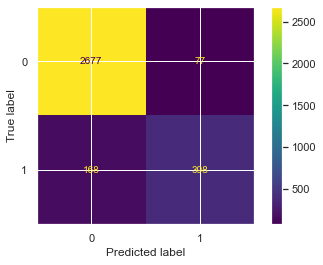

In [431]:
ConfusionMatrixDisplay.from_predictions(y_test.astype(int), preds_lgb_model)

In [438]:
#Plot feature importance
%matplotlib inline
feature_importances = pd.Series(random_lgb.feature_importances_, index=Predictors)
feature_importances.nlargest(10).plot(kind='barh')

AttributeError: 'RandomizedSearchCV' object has no attribute 'feature_importances_'

XG BOOST

In [293]:
xgb_clf=xgb.XGBClassifier()

In [294]:
xgb_random_grid = {
    'task' : ['train', 'predict'],
    'booster': ['dart','gbtree'],
    'eval_metric': ['mae', 'rmse'],
    'sample_type':['weighted', 'uniform'],
    'normalize_type': ['tree', 'forest'],
    'max_depth' :[ 10, 20, 40,60,80,100, 120],
    'min_child_weight' : [0,10,1],
    'max_bins': [100,150, 200, 250, 300],
    'reg_alpha': [0.5,1, 3, 5, 10],
    'reg_lambda': [0.5,1, 3, 5, 10],
     
 }

In [308]:
random_xgb = RandomizedSearchCV(estimator=xgb_clf, param_distributions = xgb_random_grid, n_iter=60,cv=5, verbose=2, random_state=42, n_jobs=-1)

In [309]:
random_xgb.fit(X_train,y_train.astype(int))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from p

[11:25:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:25:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:25:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=250, max_depth=100, min_child_weight=0, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=predict; total time=  34.5s
[11:25:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=250, max_depth=100, min_child_weight=0, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=predict; total time=  35.7s
[11:25:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=250, max_depth=100, min_child_weight=0, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=predict; total time=  36.3s
[11:25:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=250, max_depth=100, min_child_weight=0, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=predict; total time=  36.8s
[11:25:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=250, max_depth=100, min_child_weight=0, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=predict; total time=  37.2s
[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=20, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=0.5, sample_type=weighted, task=train; total time=  37.0s
[11:25:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:25:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_typ

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=20, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=0.5, sample_type=weighted, task=train; total time=  38.5s
[11:25:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=20, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=0.5, sample_type=weighted, task=train; total time=  39.5s
[11:25:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=250, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=10, reg_lambda=1, sample_type=uniform, task=train; total time=   5.9s
[11:25:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=250, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=10, reg_lambda=1, sample_type=uniform, task=train; total time=   5.5s
[11:26:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=250, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=10, reg_lambda=1, sample_type=uniform, task=train; total time=   5.4s
[11:26:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=250, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=10, reg_lambda=1, sample_type=uniform, task=train; total time=   6.6s
[11:26:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=250, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=10, reg_lambda=1, sample_type=uniform, task=train; total time=   5.4s
[11:26:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=40, min_child_weight=0, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=train; total time=  32.6s
[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=40, min_child_weight=0, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=train; total time=  32.2s
[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=20, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=0.5, sample_type=weighted, task=train; total time=  34.4s
[11:26:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any su

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-p

[11:26:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=40, min_child_weight=0, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=train; total time=  32.0s
[11:26:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:26:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=20, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=0.5, sample_type=weighted, task=train; total time=  34.7s
[11:26:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or 

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=40, min_child_weight=0, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=train; total time=  32.6s
[11:26:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=80, min_child_weight=0, normalize_type=forest, reg_alpha=10, reg_lambda=1, sample_type=uniform, task=train; total time=  10.7s
[11:26:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=80, min_child_weight=0, normalize_type=forest, reg_alpha=10, reg_lambda=1, sample_type=uniform, task=train; total time=  10.5s
[11:26:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=80, min_child_weight=0, normalize_type=forest, reg_alpha=10, reg_lambda=1, sample_type=uniform, task=train; total time=  11.5s
[11:26:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=80, min_child_weight=0, normalize_type=forest, reg_alpha=10, reg_lambda=1, sample_type=uniform, task=train; total time=  12.7s
[11:26:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=80, min_child_weight=0, normalize_type=forest, reg_alpha=10, reg_lambda=1, sample_type=uniform, task=train; total time=  12.5s
[11:26:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=150, max_depth=60, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=1, sample_type=weighted, task=predict; total time=  35.3s
[11:26:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=150, max_depth=60, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=1, sample_type=weighted, task=predict; total time=  37.4s
[CV] END booster=dart, eval_metric=mae, max_bins=150, max_depth=60, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=1, sample_type=weighted, task=predict; total time=  38.0s
[11:27:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:27:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might n

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=150, max_depth=60, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=1, sample_type=weighted, task=predict; total time=  38.2s
[11:27:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=150, max_depth=60, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=1, sample_type=weighted, task=predict; total time=  39.2s
[11:27:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=250, max_depth=100, min_child_weight=1, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=train; total time=  35.3s
[11:27:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=100, max_depth=60, min_child_weight=10, normalize_type=forest, reg_alpha=1, reg_lambda=3, sample_type=uniform, task=predict; total time=  20.6s
[11:27:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=250, max_depth=100, min_child_weight=1, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=train; total time=  34.5s
[11:27:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=100, max_depth=60, min_child_weight=10, normalize_type=forest, reg_alpha=1, reg_lambda=3, sample_type=uniform, task=predict; total time=  20.8s
[11:27:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=100, max_depth=60, min_child_weight=10, normalize_type=forest, reg_alpha=1, reg_lambda=3, sample_type=uniform, task=predict; total time=  20.1s
[11:27:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=250, max_depth=100, min_child_weight=1, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=train; total time=  35.0s
[11:27:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=100, max_depth=60, min_child_weight=10, normalize_type=forest, reg_alpha=1, reg_lambda=3, sample_type=uniform, task=predict; total time=  20.7s
[11:27:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=250, max_depth=100, min_child_weight=1, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=train; total time=  34.5s
[11:27:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=250, max_depth=100, min_child_weight=1, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=train; total time=  34.7s
[11:27:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=40, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  12.8s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:27:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=40, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  14.5s
[11:27:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongl

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=40, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  15.6s
[11:27:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=40, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  15.1s
[11:27:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=100, max_depth=60, min_child_weight=10, normalize_type=forest, reg_alpha=1, reg_lambda=3, sample_type=uniform, task=predict; total time=  19.5s
[11:27:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=40, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  14.0s
[11:27:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=300, max_depth=100, min_child_weight=10, normalize_type=tree, reg_alpha=10, reg_lambda=3, sample_type=uniform, task=train; total time=  30.2s
[11:28:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=300, max_depth=100, min_child_weight=10, normalize_type=tree, reg_alpha=10, reg_lambda=3, sample_type=uniform, task=train; total time=  30.7s
[11:28:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=300, max_depth=100, min_child_weight=10, normalize_type=tree, reg_alpha=10, reg_lambda=3, sample_type=uniform, task=train; total time=  31.2s
[11:28:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=250, max_depth=100, min_child_weight=1, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  53.7s
[11:28:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=250, max_depth=100, min_child_weight=1, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  52.9s
[CV] END booster=dart, eval_metric=mae, max_bins=250, max_depth=100, min_child_weight=1, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  52.8s
[11:28:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:28:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_typ

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=250, max_depth=100, min_child_weight=1, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  53.1s
[11:28:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=250, max_depth=100, min_child_weight=1, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  53.2s
[11:28:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=10, min_child_weight=0, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=predict; total time=  19.3s
[11:28:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=300, max_depth=100, min_child_weight=10, normalize_type=tree, reg_alpha=10, reg_lambda=3, sample_type=uniform, task=train; total time=  28.2s
[11:28:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=300, max_depth=100, min_child_weight=10, normalize_type=tree, reg_alpha=10, reg_lambda=3, sample_type=uniform, task=train; total time=  28.0s
[11:28:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=10, min_child_weight=0, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=predict; total time=  17.5s
[11:28:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=10, min_child_weight=0, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=predict; total time=  17.1s
[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=10, min_child_weight=0, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=predict; total time=  17.2s
[11:28:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:28:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=10, min_child_weight=0, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=predict; total time=  17.0s
[11:28:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=60, min_child_weight=0, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=train; total time=  29.9s
[11:29:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=60, min_child_weight=0, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=train; total time=  29.9s
[11:29:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=60, min_child_weight=0, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=train; total time=  29.7s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:29:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=60, min_child_weight=0, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=train; total time=  30.2s
[11:29:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, o

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=60, min_child_weight=0, normalize_type=tree, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=train; total time=  32.0s
[11:29:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=20, min_child_weight=10, normalize_type=forest, reg_alpha=1, reg_lambda=5, sample_type=uniform, task=predict; total time=  20.4s
[11:29:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=20, min_child_weight=0, normalize_type=forest, reg_alpha=5, reg_lambda=3, sample_type=weighted, task=predict; total time=  43.2s
[11:29:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=20, min_child_weight=0, normalize_type=forest, reg_alpha=5, reg_lambda=3, sample_type=weighted, task=predict; total time=  42.8s
[11:29:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=20, min_child_weight=0, normalize_type=forest, reg_alpha=5, reg_lambda=3, sample_type=weighted, task=predict; total time=  43.8s
[11:29:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=20, min_child_weight=10, normalize_type=forest, reg_alpha=1, reg_lambda=5, sample_type=uniform, task=predict; total time=  20.3s
[11:29:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=20, min_child_weight=10, normalize_type=forest, reg_alpha=1, reg_lambda=5, sample_type=uniform, task=predict; total time=  20.0s
[11:29:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=20, min_child_weight=0, normalize_type=forest, reg_alpha=5, reg_lambda=3, sample_type=weighted, task=predict; total time=  42.4s
[11:29:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=20, min_child_weight=10, normalize_type=forest, reg_alpha=1, reg_lambda=5, sample_type=uniform, task=predict; total time=  18.5s
[11:29:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=20, min_child_weight=10, normalize_type=forest, reg_alpha=1, reg_lambda=5, sample_type=uniform, task=predict; total time=  18.6s
[11:29:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=20, min_child_weight=0, normalize_type=forest, reg_alpha=5, reg_lambda=3, sample_type=weighted, task=predict; total time=  46.6s
[11:29:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=120, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=uniform, task=predict; total time=  24.8s
[11:29:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=120, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=uniform, task=predict; total time=  25.4s
[11:29:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=120, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=uniform, task=predict; total time=  24.8s
[11:29:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=120, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=uniform, task=predict; total time=  23.3s
[11:29:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=120, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=uniform, task=predict; total time=  22.8s
[11:30:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=20, min_child_weight=0, normalize_type=forest, reg_alpha=5, reg_lambda=3, sample_type=weighted, task=predict; total time=  18.8s
[11:30:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=60, min_child_weight=0, normalize_type=forest, reg_alpha=1, reg_lambda=1, sample_type=weighted, task=predict; total time=  31.4s
[11:30:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=60, min_child_weight=0, normalize_type=forest, reg_alpha=1, reg_lambda=1, sample_type=weighted, task=predict; total time=  31.0s
[11:30:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=20, min_child_weight=0, normalize_type=forest, reg_alpha=5, reg_lambda=3, sample_type=weighted, task=predict; total time=  19.6s
[11:30:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=60, min_child_weight=0, normalize_type=forest, reg_alpha=1, reg_lambda=1, sample_type=weighted, task=predict; total time=  30.1s
[11:30:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=20, min_child_weight=0, normalize_type=forest, reg_alpha=5, reg_lambda=3, sample_type=weighted, task=predict; total time=  18.6s
[11:30:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=60, min_child_weight=0, normalize_type=forest, reg_alpha=1, reg_lambda=1, sample_type=weighted, task=predict; total time=  31.2s
[11:30:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=60, min_child_weight=0, normalize_type=forest, reg_alpha=1, reg_lambda=1, sample_type=weighted, task=predict; total time=  31.0s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:30:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=20, min_child_weight=0, normalize_type=forest, reg_alpha=5, reg_lambda=3, sample_type=weighted, task=predict; total time=  16.4s
[11:30:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core,

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=20, min_child_weight=0, normalize_type=forest, reg_alpha=5, reg_lambda=3, sample_type=weighted, task=predict; total time=  21.2s
[11:30:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=100, min_child_weight=10, normalize_type=forest, reg_alpha=0.5, reg_lambda=1, sample_type=weighted, task=train; total time=  20.4s
[11:30:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=100, min_child_weight=10, normalize_type=forest, reg_alpha=0.5, reg_lambda=1, sample_type=weighted, task=train; total time=  21.3s
[11:30:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=100, min_child_weight=10, normalize_type=forest, reg_alpha=0.5, reg_lambda=1, sample_type=weighted, task=train; total time=  21.2s
[11:30:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=100, min_child_weight=10, normalize_type=forest, reg_alpha=0.5, reg_lambda=1, sample_type=weighted, task=train; total time=  22.0s
[11:31:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=150, max_depth=20, min_child_weight=1, normalize_type=forest, reg_alpha=0.5, reg_lambda=3, sample_type=uniform, task=predict; total time=  55.2s
[11:31:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=100, min_child_weight=10, normalize_type=forest, reg_alpha=0.5, reg_lambda=1, sample_type=weighted, task=train; total time=  22.5s
[11:31:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=150, max_depth=20, min_child_weight=1, normalize_type=forest, reg_alpha=0.5, reg_lambda=3, sample_type=uniform, task=predict; total time=  55.3s
[11:31:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=150, max_depth=20, min_child_weight=1, normalize_type=forest, reg_alpha=0.5, reg_lambda=3, sample_type=uniform, task=predict; total time=  56.5s
[11:31:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=150, max_depth=20, min_child_weight=1, normalize_type=forest, reg_alpha=0.5, reg_lambda=3, sample_type=uniform, task=predict; total time=  56.8s
[11:31:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=150, max_depth=20, min_child_weight=1, normalize_type=forest, reg_alpha=0.5, reg_lambda=3, sample_type=uniform, task=predict; total time=  56.8s
[11:31:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=mae, max_bins=200, max_depth=100, min_child_weight=10, normalize_type=forest, reg_alpha=0.5, reg_lambda=1, sample_type=uniform, task=predict; total time=  22.6s
[11:31:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=200, max_depth=100, min_child_weight=10, normalize_type=forest, reg_alpha=0.5, reg_lambda=1, sample_type=uniform, task=predict; total time=  22.6s
[11:31:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=200, max_depth=100, min_child_weight=10, normalize_type=forest, reg_alpha=0.5, reg_lambda=1, sample_type=uniform, task=predict; total time=  21.4s
[11:31:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=200, max_depth=100, min_child_weight=10, normalize_type=forest, reg_alpha=0.5, reg_lambda=1, sample_type=uniform, task=predict; total time=  21.7s
[11:31:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=200, max_depth=100, min_child_weight=10, normalize_type=forest, reg_alpha=0.5, reg_lambda=1, sample_type=uniform, task=predict; total time=  21.7s
[11:31:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=200, max_depth=10, min_child_weight=1, normalize_type=forest, reg_alpha=1, reg_lambda=5, sample_type=weighted, task=train; total time=  19.4s
[11:31:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=rmse, max_bins=150, max_depth=100, min_child_weight=1, normalize_type=tree, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=predict; total time=  34.8s
[11:31:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_t

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=150, max_depth=100, min_child_weight=1, normalize_type=tree, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=predict; total time=  33.6s
[11:31:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=200, max_depth=10, min_child_weight=1, normalize_type=forest, reg_alpha=1, reg_lambda=5, sample_type=weighted, task=train; total time=  19.9s
[11:31:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=rmse, max_bins=200, max_depth=10, min_child_weight=1, normalize_type=forest, reg_alpha=1, reg_lambda=5, sample_type=weighted, task=train; total time=  19.7s
[11:31:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be 

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=150, max_depth=100, min_child_weight=1, normalize_type=tree, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=predict; total time=  34.1s
[11:31:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=rmse, max_bins=150, max_depth=100, min_child_weight=1, normalize_type=tree, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=predict; total time=  34.2s
[11:31:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be 

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=150, max_depth=100, min_child_weight=1, normalize_type=tree, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=predict; total time=  34.6s
[11:32:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=200, max_depth=10, min_child_weight=1, normalize_type=forest, reg_alpha=1, reg_lambda=5, sample_type=weighted, task=train; total time=  18.3s
[11:32:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=200, max_depth=10, min_child_weight=1, normalize_type=forest, reg_alpha=1, reg_lambda=5, sample_type=weighted, task=train; total time=  18.8s
[11:32:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=150, max_depth=10, min_child_weight=1, normalize_type=tree, reg_alpha=3, reg_lambda=10, sample_type=uniform, task=train; total time=  41.9s
[11:32:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=150, max_depth=10, min_child_weight=1, normalize_type=tree, reg_alpha=3, reg_lambda=10, sample_type=uniform, task=train; total time=  42.4s
[CV] END booster=dart, eval_metric=rmse, max_bins=150, max_depth=10, min_child_weight=1, normalize_type=tree, reg_alpha=3, reg_lambda=10, sample_type=uniform, task=train; total time=  42.4s
[11:32:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:32:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false 

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=150, max_depth=10, min_child_weight=1, normalize_type=tree, reg_alpha=3, reg_lambda=10, sample_type=uniform, task=train; total time=  42.1s
[11:32:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=rmse, max_bins=150, max_depth=10, min_child_weight=1, normalize_type=tree, reg_alpha=3, reg_lambda=10, sample_type=uniform, task=train; total time=  42.0s
[11:32:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false 

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=300, max_depth=40, min_child_weight=1, normalize_type=tree, reg_alpha=1, reg_lambda=3, sample_type=uniform, task=predict; total time=  58.2s
[11:33:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=300, max_depth=40, min_child_weight=1, normalize_type=tree, reg_alpha=1, reg_lambda=3, sample_type=uniform, task=predict; total time=  58.2s
[11:33:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=300, max_depth=40, min_child_weight=1, normalize_type=tree, reg_alpha=1, reg_lambda=3, sample_type=uniform, task=predict; total time=  58.8s
[11:33:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=80, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=1, sample_type=uniform, task=predict; total time=  43.1s
[11:33:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=80, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=1, sample_type=uniform, task=predict; total time=  43.4s
[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=80, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=1, sample_typ

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-p

[11:33:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=3, sample_type=uniform, task=train; total time=  15.1s
[11:33:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=300, max_depth=40, min_child_weight=1, normalize_type=tree, reg_alpha=1, reg_lambda=3, sample_type=uniform, task=predict; total time=  59.3s
[11:33:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=3, sample_type=uniform, task=train; total time=  15.1s
[11:33:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=3, sample_type=uniform, task=train; total time=  15.2s
[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=3, sample_t

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-p

[CV] END booster=dart, eval_metric=mae, max_bins=300, max_depth=40, min_child_weight=1, normalize_type=tree, reg_alpha=1, reg_lambda=3, sample_type=uniform, task=predict; total time=  59.5s
[11:33:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=3, sample_type=uniform, task=train; total time=  14.5s
[11:33:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=80, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=1, sample_type=uniform, task=predict; total time=  43.6s
[11:33:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=80, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=1, sample_type=uniform, task=predict; total time=  43.1s
[11:33:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=80, min_child_weight=10, normalize_type=forest, reg_alpha=1, reg_lambda=1, sample_type=weighted, task=predict; total time=  20.3s
[11:33:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=80, min_child_weight=10, normalize_type=forest, reg_alpha=1, reg_lambda=1, sample_type=weighted, task=predict; total time=  20.6s
[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=80, min_child_weight=10, normalize_type=forest, reg_alpha=1, reg_lambda=1, sample_type=weighted, task=predict; total time=  20.6s
[11:33:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:33:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task"

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-p

[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=80, min_child_weight=10, normalize_type=forest, reg_alpha=1, reg_lambda=1, sample_type=weighted, task=predict; total time=  20.4s
[11:33:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=1, reg_lambda=5, sample_type=uniform, task=predict; total time=  14.0s
[11:34:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=1, reg_lambda=5, sample_type=uniform, task=predict; total time=  14.1s
[11:34:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=1, reg_lambda=5, sample_type=uniform, task=predict; total time=  14.2s
[11:34:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=250, max_depth=60, min_child_weight=10, normalize_type=forest, reg_alpha=5, reg_lambda=5, sample_type=weighted, task=predict; total time=  40.6s
[11:34:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=mae, max_bins=250, max_depth=60, min_child_weight=1, normalize_type=tree, reg_alpha=10, reg_lambda=1, sample_type=uniform, task=train; total time=  10.0s
[11:34:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_typ

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=1, reg_lambda=5, sample_type=uniform, task=predict; total time=  14.1s
[11:34:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=1, reg_lambda=5, sample_type=uniform, task=predict; total time=  14.2s
[11:34:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=250, max_depth=60, min_child_weight=10, normalize_type=forest, reg_alpha=5, reg_lambda=5, sample_type=weighted, task=predict; total time=  40.9s
[11:34:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=250, max_depth=60, min_child_weight=1, normalize_type=tree, reg_alpha=10, reg_lambda=1, sample_type=uniform, task=train; total time=   9.0s
[11:34:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=250, max_depth=60, min_child_weight=1, normalize_type=tree, reg_alpha=10, reg_lambda=1, sample_type=uniform, task=train; total time=   9.6s
[11:34:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=250, max_depth=60, min_child_weight=10, normalize_type=forest, reg_alpha=5, reg_lambda=5, sample_type=weighted, task=predict; total time=  40.9s
[11:34:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=250, max_depth=60, min_child_weight=1, normalize_type=tree, reg_alpha=10, reg_lambda=1, sample_type=uniform, task=train; total time=  10.8s
[CV] END booster=gbtree, eval_metric=mae, max_bins=250, max_depth=60, min_child_weight=1, normalize_type=tree, reg_alpha=10, reg_lambda=1, sample_type=uniform, task=train; total time=  10.4s
[11:34:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:34:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=250, max_depth=60, min_child_weight=10, normalize_type=forest, reg_alpha=5, reg_lambda=5, sample_type=weighted, task=predict; total time=  40.7s
[11:34:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=250, max_depth=60, min_child_weight=10, normalize_type=forest, reg_alpha=5, reg_lambda=5, sample_type=weighted, task=predict; total time=  40.8s
[11:34:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=120, min_child_weight=10, normalize_type=tree, reg_alpha=0.5, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  22.1s
[11:34:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=120, min_child_weight=10, normalize_type=tree, reg_alpha=0.5, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  22.2s
[11:34:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=120, min_child_weight=10, normalize_type=tree, reg_alpha=0.5, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  21.8s
[11:34:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=120, min_child_weight=10, normalize_type=tree, reg_alpha=0.5, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  21.9s
[11:34:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=120, min_child_weight=10, normalize_type=tree, reg_alpha=0.5, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  22.3s
[11:34:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=200, max_depth=60, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=3, sample_type=uniform, task=predict; total time=  43.4s
[11:35:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=200, max_depth=60, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=3, sample_type=uniform, task=predict; total time=  43.8s
[11:35:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=200, max_depth=60, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=3, sample_type=uniform, task=predict; total time=  43.6s
[11:35:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=80, min_child_weight=1, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=train; total time=  37.0s
[11:35:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=80, min_child_weight=1, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=train; total time=  35.9s
[11:35:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=60, min_child_weight=0, normalize_type=tree, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=train; total time=  11.7s
[11:35:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=rmse, max_bins=200, max_depth=60, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=3, sample_type=uniform, task=predict; total time=  43.8s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=80, min_child_weight=1, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=train; total time=  36.5s
[11:35:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=200, max_depth=60, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=3, sample_type=uniform, task=predict; total time=  43.8s
[11:35:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=60, min_child_weight=0, normalize_type=tree, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=train; total time=  12.5s
[11:35:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=60, min_child_weight=0, normalize_type=tree, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=train; total time=  10.5s
[11:35:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a 

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=60, min_child_weight=0, normalize_type=tree, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=train; total time=  12.9s
[11:35:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=60, min_child_weight=0, normalize_type=tree, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=train; total time=  13.4s
[11:35:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=80, min_child_weight=1, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=train; total time=  35.3s
[11:35:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=80, min_child_weight=1, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=train; total time=  35.6s
[11:35:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=120, min_child_weight=10, normalize_type=tree, reg_alpha=10, reg_lambda=3, sample_type=uniform, task=train; total time=  31.6s
[11:36:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=120, min_child_weight=10, normalize_type=tree, reg_alpha=10, reg_lambda=3, sample_type=uniform, task=train; total time=  31.7s
[11:36:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=120, min_child_weight=10, normalize_type=tree, reg_alpha=10, reg_lambda=3, sample_type=uniform, task=train; total time=  30.6s
[11:36:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=120, min_child_weight=10, normalize_type=tree, reg_alpha=10, reg_lambda=3, sample_type=uniform, task=train; total time=  31.2s
[11:36:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=100, max_depth=120, min_child_weight=10, normalize_type=tree, reg_alpha=10, reg_lambda=3, sample_type=uniform, task=train; total time=  31.4s
[11:36:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=1, reg_lambda=10, sample_type=uniform, task=train; total time=  14.6s
[11:36:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=1, reg_lambda=10, sample_type=uniform, task=train; total time=  14.9s
[11:36:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=1, reg_lambda=10, sample_type=uniform, task=train; total time=  14.9s
[11:36:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=300, max_depth=120, min_child_weight=10, normalize_type=tree, reg_alpha=0.5, reg_lambda=1, sample_type=uniform, task=train; total time=  48.0s
[11:36:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=1, reg_lambda=10, sample_type=uniform, task=train; total time=  14.1s
[11:36:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=300, max_depth=120, min_child_weight=10, normalize_type=tree, reg_alpha=0.5, reg_lambda=1, sample_type=uniform, task=train; total time=  48.5s
[11:36:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=1, reg_lambda=10, sample_type=uniform, task=train; total time=  14.2s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=rmse, max_bins=300, max_depth=120, min_child_weight=10, normalize_type=tree, reg_alpha=0.5, reg_lambda=1, sample_type=uniform, task=train; total time=  47.4s
[11:36:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly 

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=300, max_depth=120, min_child_weight=10, normalize_type=tree, reg_alpha=0.5, reg_lambda=1, sample_type=uniform, task=train; total time=  46.9s
[11:36:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=300, max_depth=120, min_child_weight=10, normalize_type=tree, reg_alpha=0.5, reg_lambda=1, sample_type=uniform, task=train; total time=  47.2s
[11:36:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=10, min_child_weight=10, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=train; total time=  31.0s
[11:37:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=10, min_child_weight=10, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=train; total time=  31.7s
[11:37:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=10, min_child_weight=10, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=train; total time=  31.5s
[11:37:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=60, min_child_weight=1, normalize_type=tree, reg_alpha=1, reg_lambda=1, sample_type=uniform, task=predict; total time=  57.6s
[11:37:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=60, min_child_weight=1, normalize_type=tree, reg_alpha=1, reg_lambda=1, sample_type=uniform, task=predict; total time=  57.0s
[11:37:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=60, min_child_weight=1, normalize_type=tree, reg_alpha=1, reg_lambda=1, sample_type=uniform, task=predict; total time=  56.2s
[11:37:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=60, min_child_weight=1, normalize_type=tree, reg_alpha=1, reg_lambda=1, sample_type=uniform, task=predict; total time=  56.1s
[11:37:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=60, min_child_weight=1, normalize_type=tree, reg_alpha=1, reg_lambda=1, sample_type=uniform, task=predict; total time=  56.0s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:37:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=10, min_child_weight=10, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=train; total time=  31.4s
[11:37:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=200, max_depth=80, min_child_weight=0, normalize_type=forest, reg_alpha=5, reg_lambda=3, sample_type=weighted, task=predict; total time=  19.3s
[11:37:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=200, max_depth=80, min_child_weight=0, normalize_type=forest, reg_alpha=5, reg_lambda=3, sample_type=weighted, task=predict; total time=  19.2s
[11:37:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=200, max_depth=80, min_child_weight=0, normalize_type=forest, reg_alpha=5, reg_lambda=3, sample_type=weighted, task=predict; total time=  23.8s
[11:37:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=10, min_child_weight=10, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=train; total time=  28.8s
[11:37:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=200, max_depth=80, min_child_weight=0, normalize_type=forest, reg_alpha=5, reg_lambda=3, sample_type=weighted, task=predict; total time=  19.4s
[11:37:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=200, max_depth=80, min_child_weight=0, normalize_type=forest, reg_alpha=5, reg_lambda=3, sample_type=weighted, task=predict; total time=  21.2s
[11:38:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=100, max_depth=20, min_child_weight=1, normalize_type=tree, reg_alpha=0.5, reg_lambda=0.5, sample_type=weighted, task=predict; total time=  26.5s
[11:38:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=20, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=weighted, task=train; total time=  15.1s
[11:38:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=100, max_depth=20, min_child_weight=1, normalize_type=tree, reg_alpha=0.5, reg_lambda=0.5, sample_type=weighted, task=predict; total time=  27.0s
[11:38:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=20, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=weighted, task=train; total time=  15.9s
[11:38:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=20, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=weighted, task=train; total time=  15.7s
[11:38:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=100, max_depth=20, min_child_weight=1, normalize_type=tree, reg_alpha=0.5, reg_lambda=0.5, sample_type=weighted, task=predict; total time=  26.9s
[11:38:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=100, max_depth=20, min_child_weight=1, normalize_type=tree, reg_alpha=0.5, reg_lambda=0.5, sample_type=weighted, task=predict; total time=  26.7s
[11:38:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=100, max_depth=20, min_child_weight=1, normalize_type=tree, reg_alpha=0.5, reg_lambda=0.5, sample_type=weighted, task=predict; total time=  27.3s
[11:38:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=20, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=weighted, task=train; total time=  16.3s
[11:38:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=20, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=weighted, task=train; total time=  16.6s
[11:38:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=20, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=3, sample_type=weighted, task=train; total time=  18.3s
[11:38:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=20, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=3, sample_type=weighted, task=train; total time=  18.5s
[11:38:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=20, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=3, sample_type=weighted, task=train; total time=  18.3s
[11:38:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=100, max_depth=80, min_child_weight=1, normalize_type=tree, reg_alpha=10, reg_lambda=10, sample_type=weighted, task=predict; total time=  34.4s
[11:38:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=100, max_depth=80, min_child_weight=1, normalize_type=tree, reg_alpha=10, reg_lambda=10, sample_type=weighted, task=predict; total time=  34.2s
[11:38:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=rmse, max_bins=100, max_depth=80, min_child_weight=1, normalize_type=tree, reg_alpha=10, reg_lambda=10, sample_type=weighted, task=predict; total time=  35.4s
[11:38:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be 

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=100, max_depth=80, min_child_weight=1, normalize_type=tree, reg_alpha=10, reg_lambda=10, sample_type=weighted, task=predict; total time=  34.9s
[11:38:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=100, max_depth=80, min_child_weight=1, normalize_type=tree, reg_alpha=10, reg_lambda=10, sample_type=weighted, task=predict; total time=  34.0s
[11:38:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=20, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=3, sample_type=weighted, task=train; total time=  17.0s
[11:38:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=20, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=3, sample_type=weighted, task=train; total time=  16.9s
[11:38:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=100, max_depth=80, min_child_weight=0, normalize_type=tree, reg_alpha=10, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  34.9s
[11:39:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=150, max_depth=60, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=uniform, task=predict; total time=  27.3s
[11:39:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=150, max_depth=60, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=uniform, task=predict; total time=  26.6s
[11:39:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=100, max_depth=80, min_child_weight=0, normalize_type=tree, reg_alpha=10, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  33.8s
[11:39:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=100, max_depth=80, min_child_weight=0, normalize_type=tree, reg_alpha=10, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  32.8s
[11:39:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=100, max_depth=80, min_child_weight=0, normalize_type=tree, reg_alpha=10, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  34.2s
[11:39:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=150, max_depth=60, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=uniform, task=predict; total time=  26.8s
[11:39:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=100, max_depth=80, min_child_weight=0, normalize_type=tree, reg_alpha=10, reg_lambda=0.5, sample_type=uniform, task=predict; total time=  34.9s
[11:39:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=10, sample_type=weighted, task=predict; total time=  14.3s
[11:39:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=150, max_depth=60, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=uniform, task=predict; total time=  27.0s
[11:39:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=150, max_depth=60, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=uniform, task=predict; total time=  27.7s
[11:39:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=10, sample_type=weighted, task=predict; total time=  14.4s
[11:39:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=uniform, task=predict; total time=  38.6s
[11:39:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=10, sample_type=weighted, task=predict; total time=  14.8s
[11:40:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=uniform, task=predict; total time=  39.0s
[11:40:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=10, sample_type=weighted, task=predict; total time=  14.5s
[11:40:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=uniform, task=predict; total time=  39.0s
[11:40:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=uniform, task=predict; total time=  39.0s
[11:40:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=uniform, task=predict; total time=  38.9s
[11:40:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=300, max_depth=10, min_child_weight=10, normalize_type=tree, reg_alpha=5, reg_lambda=10, sample_type=weighted, task=predict; total time=  12.9s
[11:40:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=120, min_child_weight=1, normalize_type=forest, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=predict; total time=  27.1s
[11:40:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=120, min_child_weight=1, normalize_type=forest, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=predict; total time=  27.9s
[11:40:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=120, min_child_weight=1, normalize_type=forest, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=predict; total time=  28.0s
[11:40:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=250, max_depth=60, min_child_weight=1, normalize_type=forest, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=train; total time=  51.6s
[11:40:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=rmse, max_bins=250, max_depth=60, min_child_weight=1, normalize_type=forest, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=train; total time=  50.7s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:40:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=rmse, max_bins=250, max_depth=60, min_child_weight=1, normalize_type=forest, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=train; total time=  50.6s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:40:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=rmse, max_bins=250, max_depth=60, min_child_weight=1, normalize_type=forest, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=train; total time=  50.6s
[11:40:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, o

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=250, max_depth=60, min_child_weight=1, normalize_type=forest, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=train; total time=  51.0s
[11:40:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=60, min_child_weight=1, normalize_type=tree, reg_alpha=5, reg_lambda=10, sample_type=uniform, task=predict; total time=  21.2s
[11:40:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=120, min_child_weight=1, normalize_type=forest, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=predict; total time=  28.7s
[11:40:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=120, min_child_weight=1, normalize_type=forest, reg_alpha=1, reg_lambda=0.5, sample_type=weighted, task=predict; total time=  29.0s
[11:41:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=60, min_child_weight=1, normalize_type=tree, reg_alpha=5, reg_lambda=10, sample_type=uniform, task=predict; total time=  18.8s
[11:41:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=60, min_child_weight=1, normalize_type=tree, reg_alpha=5, reg_lambda=10, sample_type=uniform, task=predict; total time=  20.8s
[11:41:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=60, min_child_weight=1, normalize_type=tree, reg_alpha=5, reg_lambda=10, sample_type=uniform, task=predict; total time=  21.9s
[11:41:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=rmse, max_bins=150, max_depth=60, min_child_weight=1, normalize_type=tree, reg_alpha=5, reg_lambda=10, sample_type=uniform, task=predict; total time=  22.4s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:41:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=mae, max_bins=300, max_depth=80, min_child_weight=10, normalize_type=tree, reg_alpha=3, reg_lambda=10, sample_type=weighted, task=predict; total time=  40.1s
[11:41:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=300, max_depth=80, min_child_weight=10, normalize_type=tree, reg_alpha=3, reg_lambda=10, sample_type=weighted, task=predict; total time=  40.6s
[11:41:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=300, max_depth=80, min_child_weight=10, normalize_type=tree, reg_alpha=3, reg_lambda=10, sample_type=weighted, task=predict; total time=  40.8s
[11:41:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=100, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=weighted, task=predict; total time=  28.4s
[11:41:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=100, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=weighted, task=predict; total time=  27.1s
[11:41:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=100, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=weighted, task=predict; total time=  27.5s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:41:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=mae, max_bins=300, max_depth=80, min_child_weight=10, normalize_type=tree, reg_alpha=3, reg_lambda=10, sample_type=weighted, task=predict; total time=  41.0s
[11:41:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=40, min_child_weight=10, normalize_type=forest, reg_alpha=10, reg_lambda=3, sample_type=weighted, task=predict; total time=   7.2s
[11:41:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=40, min_child_weight=10, normalize_type=forest, reg_alpha=10, reg_lambda=3, sample_type=weighted, task=predict; total time=   6.6s
[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=40, min_child_weight=10, normalize_type=forest, reg_alpha=10, reg_lambda=3, sample_type=weighted, task=predict; total time=   7.3s
[11:41:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:41:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "nor

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=40, min_child_weight=10, normalize_type=forest, reg_alpha=10, reg_lambda=3, sample_type=weighted, task=predict; total time=   7.1s
[11:41:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=40, min_child_weight=10, normalize_type=forest, reg_alpha=10, reg_lambda=3, sample_type=weighted, task=predict; total time=   7.3s
[11:41:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=300, max_depth=80, min_child_weight=10, normalize_type=tree, reg_alpha=3, reg_lambda=10, sample_type=weighted, task=predict; total time=  41.1s
[11:41:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=100, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=weighted, task=predict; total time=  27.0s
[11:42:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=200, max_depth=80, min_child_weight=0, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=predict; total time=  11.1s
[11:42:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=100, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=weighted, task=predict; total time=  16.9s
[11:42:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=100, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=weighted, task=predict; total time=  16.6s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:42:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=100, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=weighted, task=predict; total time=  16.9s
[11:42:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually bei

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=100, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=weighted, task=predict; total time=  17.5s
[11:42:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=gbtree, eval_metric=rmse, max_bins=100, max_depth=100, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=weighted, task=predict; total time=  27.4s


/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=rmse, max_bins=250, max_depth=100, min_child_weight=10, normalize_type=forest, reg_alpha=3, reg_lambda=5, sample_type=weighted, task=predict; total time=  16.9s
[11:42:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:42:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wro

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=200, max_depth=80, min_child_weight=0, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=predict; total time=  11.1s
[11:42:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=200, max_depth=80, min_child_weight=0, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=predict; total time=   9.0s
[11:42:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=200, max_depth=80, min_child_weight=0, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=predict; total time=  11.3s
[11:42:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=gbtree, eval_metric=mae, max_bins=200, max_depth=80, min_child_weight=0, normalize_type=forest, reg_alpha=10, reg_lambda=5, sample_type=uniform, task=predict; total time=  11.7s
[11:42:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=40, min_child_weight=0, normalize_type=tree, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=train; total time=  36.5s
[11:42:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=40, min_child_weight=0, normalize_type=tree, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=train; total time=  35.8s
[11:42:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=40, min_child_weight=0, normalize_type=tree, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=train; total time=  38.1s
[11:42:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=300, max_depth=80, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=weighted, task=predict; total time=  52.5s
[11:42:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=rmse, max_bins=300, max_depth=80, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=weighted, task=predict; total time=  52.8s
[11:42:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=300, max_depth=80, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=weighted, task=predict; total time=  52.8s
[11:42:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize_type", "sample_type", "task" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END booster=dart, eval_metric=rmse, max_bins=300, max_depth=80, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=weighted, task=predict; total time=  53.4s
[11:42:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_bins", "normalize

/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sofiaburzaco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END booster=dart, eval_metric=rmse, max_bins=300, max_depth=80, min_child_weight=1, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=weighted, task=predict; total time=  53.5s
[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=40, min_child_weight=0, normalize_type=tree, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=train; total time=  31.9s
[CV] END booster=dart, eval_metric=mae, max_bins=200, max_depth=40, min_child_weight=0, normalize_type=tree, reg_alpha=10, reg_lambda=5, sample_type=weighted, task=train; total time=  30.7s
[CV] END booster=gbtree, eval_metric=mae, max_bins=100, max_depth=120, min_child_weight=0, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=uniform, task=train; total time=  29.2s
[CV] END booster=gbtree, eval_metric=mae, max_bins=100, max_depth=120, min_child_weight=0, normalize_type=forest, reg_alpha=3, reg_lambda=10, sample_type=uniform, task=train; total time=  26.6s
[CV] END booster=gbtree, eval_metric=

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                   param_distributions={'booster': ['dart', 'gbtree'],
                                        'eval_metric': ['mae', 'rmse'],
                                      

In [310]:
random_xgb.best_params_

{'task': 'train',
 'sample_type': 'uniform',
 'reg_lambda': 3,
 'reg_alpha': 10,
 'normalize_type': 'tree',
 'min_child_weight': 10,
 'max_depth': 100,
 'max_bins': 300,
 'eval_metric': 'rmse',
 'booster': 'dart'}

In [311]:
preds_xgb_model = random_xgb.predict(X_test)

In [318]:
best_xgb_model=random_xgb.best_estimator_

In [312]:
accuracy_score(y_test.astype(int), preds_xgb_model)

0.9259036144578313

In [313]:
roc_auc_score(y_test.astype(int), preds_xgb_model)

0.8486582959319049

In [314]:
average_precision_score(y_test.astype(int), preds_xgb_model)

0.6418850773841868

In [315]:
print(classification_report(y_test.astype(int), preds_xgb_model))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2754
           1       0.81      0.73      0.77       566

    accuracy                           0.93      3320
   macro avg       0.88      0.85      0.86      3320
weighted avg       0.92      0.93      0.92      3320



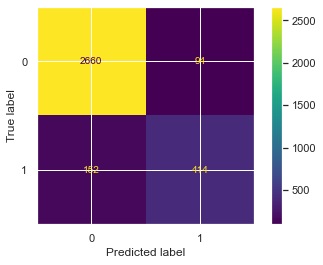

In [316]:
ConfusionMatrixDisplay.from_predictions(y_test.astype(int), preds_xgb_model)

<AxesSubplot:>

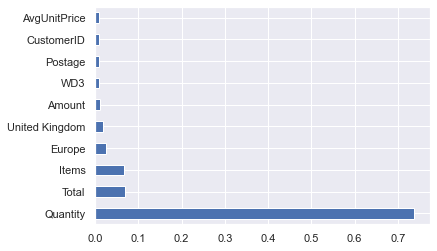

In [320]:
#Plot feature importance
%matplotlib inline
feature_importances = pd.Series(best_xgb_model.feature_importances_, index=Predictors)
feature_importances.nlargest(10).plot(kind='barh')

VALIDATION

DECISION TREE

In [404]:
preds_arbol = best_arbol.predict(X_val)

In [406]:
accuracy_score(y_val.astype(int), preds_arbol)

0.9195783132530121

In [486]:
recall_score(y_val.astype(int), preds_arbol, average=None)

array([0.93709091, 0.83508772])

In [487]:
precision_score(y_val.astype(int), preds_arbol, average=None)

array([0.96480719, 0.73343606])

In [488]:
f1_score(y_val.astype(int), preds_arbol, average=None)

array([0.95074709, 0.78096801])

In [407]:
roc_auc_score(y_val.astype(int), preds_arbol)

0.8860893141945773

In [408]:
average_precision_score(y_val.astype(int), preds_arbol)

0.6407966958255535

In [405]:
print(classification_report(y_val.astype(int), preds_arbol))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2750
           1       0.73      0.84      0.78       570

    accuracy                           0.92      3320
   macro avg       0.85      0.89      0.87      3320
weighted avg       0.93      0.92      0.92      3320



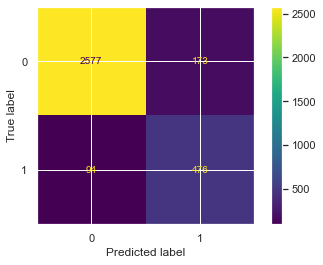

In [409]:
ConfusionMatrixDisplay.from_predictions(y_val.astype(int), preds_arbol)

RANDOM FOREST

In [446]:
val_rf = best_random.predict(X_test)

In [447]:
accuracy_score(y_val.astype(int), val_rf)

0.7180722891566265

In [448]:
roc_auc_score(y_val.astype(int), val_rf)

0.4925614035087719

In [449]:
average_precision_score(y_val.astype(int), val_rf)

0.16973254368613494

In [482]:
f1_score(y_val.astype(int), val_rf, average=None)

array([0.83086375, 0.15370705])

In [483]:
recall_score(y_val.astype(int), val_rf, average=None)

array([0.836     , 0.14912281])

In [485]:
precision_score(y_val.astype(int), val_rf, average=None)

array([0.82579023, 0.15858209])

In [450]:
print(classification_report(y_val.astype(int), val_rf))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      2750
           1       0.16      0.15      0.15       570

    accuracy                           0.72      3320
   macro avg       0.49      0.49      0.49      3320
weighted avg       0.71      0.72      0.71      3320



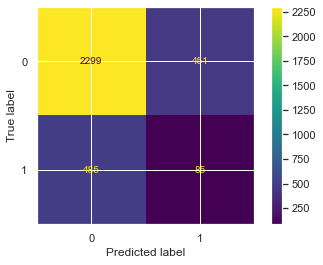

In [451]:
ConfusionMatrixDisplay.from_predictions(y_val.astype(int), val_rf)

ADABOOST

In [452]:
val_ada = best_ada.predict(X_val)

In [453]:
accuracy_score(y_val.astype(int), val_ada)

0.9201807228915663

In [454]:
roc_auc_score(y_val.astype(int), val_ada)

0.8697639553429027

In [455]:
average_precision_score(y_val.astype(int), val_ada)

0.6339195813215078

In [479]:
f1_score(y_val.astype(int), val_ada, average=None)

array([0.95156279, 0.77331052])

In [480]:
recall_score(y_val.astype(int), val_ada, average=None)

array([0.94654545, 0.79298246])

In [481]:
precision_score(y_val.astype(int), val_ada, average=None)

array([0.95663359, 0.75459098])

In [456]:
print(classification_report(y_val.astype(int), val_ada))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2750
           1       0.75      0.79      0.77       570

    accuracy                           0.92      3320
   macro avg       0.86      0.87      0.86      3320
weighted avg       0.92      0.92      0.92      3320



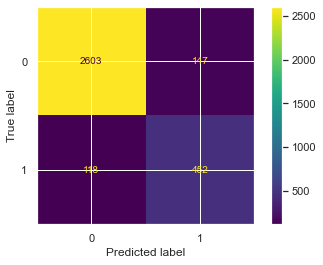

In [457]:
ConfusionMatrixDisplay.from_predictions(y_val.astype(int), val_ada)

LIGHTGBM

In [458]:
val_lgbm = random_lgb.predict(X_val)

In [459]:
accuracy_score(y_val.astype(int), val_lgbm)

0.9210843373493975

In [460]:
roc_auc_score(y_val.astype(int), val_lgbm)

0.8362360446570973

In [461]:
average_precision_score(y_val.astype(int), val_lgbm)

0.6224459240470654

In [476]:
f1_score(y_val.astype(int), val_lgbm, average=None)

array([0.95297918, 0.75468165])

In [477]:
recall_score(y_val.astype(int), val_lgbm, average=None)

array([0.96545455, 0.70701754])

In [478]:
precision_score(y_val.astype(int), val_lgbm, average=None)

array([0.94082211, 0.80923695])

In [462]:
print(classification_report(y_val.astype(int), val_lgbm))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2750
           1       0.81      0.71      0.75       570

    accuracy                           0.92      3320
   macro avg       0.88      0.84      0.85      3320
weighted avg       0.92      0.92      0.92      3320



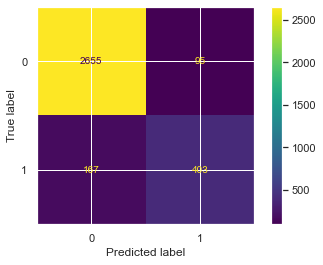

In [463]:
ConfusionMatrixDisplay.from_predictions(y_val.astype(int), val_lgbm)

XGBOOST

In [464]:
val_xgb = best_xgb_model.predict(X_val)

In [465]:
accuracy_score(y_val.astype(int), val_xgb)

0.9256024096385542

In [466]:
average_precision_score(y_val.astype(int), val_xgb)

0.6449763399949543

In [473]:
precision_score(y_val.astype(int), val_xgb, average=None)

array([0.9480845 , 0.80645161])

In [474]:
recall_score(y_val.astype(int), val_xgb, average=None)

array([0.96290909, 0.74561404])

In [475]:
f1_score(y_val.astype(int), val_xgb, average=None)

array([0.95543929, 0.77484047])

In [467]:
print(classification_report(y_val.astype(int), val_xgb))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2750
           1       0.81      0.75      0.77       570

    accuracy                           0.93      3320
   macro avg       0.88      0.85      0.87      3320
weighted avg       0.92      0.93      0.92      3320



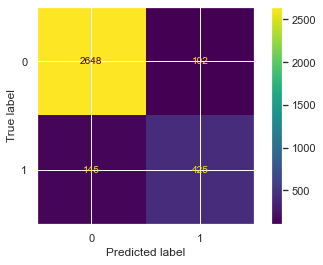

In [469]:
ConfusionMatrixDisplay.from_predictions(y_val.astype(int), val_xgb)